# Group 14 - Project FP01
## Time series anomaly detection - Isolation Forest Classifier

This project aims at investigating the current state-of-the-arts TAD scenario.

In [1]:
# %pip install --no-binary :all: -r requirements.txt

In [2]:
# %pip install numpy==1.26.4
# %pip install pandas==1.5.3
# %pip install tensorflow
# %pip install tsfel
# %pip install keras_tuner
# %pip install -U kaleido
# %pip install seaborn
# %pip install plotly
# %pip install openpyxl

In [3]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest

from src.dataset import get_df_action, get_features_ts, get_train_test_data, label_collision_data
from src.plots import seaborn_cm, create_and_plot_cm, plot_uncertainty, plot_signals, plot_anomalies, plot_anomalies_over_time, plot_anomalies_over_time_isolation_forest, plot_roc_curve
from src.metrics import Confidence, anomaly_detection_metric, compute_metrics

# from google.colab import drive
# drive.mount('/content/drive', force_remount=True)

# Set style for matplotlib
plt.style.use("Solarize_Light2")

In [4]:
# from google.colab import drive
# drive.mount('/content/drive')

In [5]:
# Path to the root directory of the dataset
ROOTDIR_DATASET_NORMAL =  './dataset/normal' #'/content/drive/MyDrive/dataset/normal'
ROOTDIR_DATASET_ANOMALY = './dataset/collisions'#'/content/drive/MyDrive/dataset/collisions'

# TF_ENABLE_ONEDNN_OPTS=0 means that the model will not use the oneDNN library for optimization

import os
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'

### Dataset: Kuka-v1
In 5 different recording sessions, the robot executes several different operations, while being
monitored by several sensors. The sensed signals are collected, with different sampling frequencies
(1, 10, 100, 200 Hz),

### Data Loading

In [6]:
#freq = '1.0'
freq = '0.1'
#freq = '0.01'
#freq = '0.005'

# NORMAL DATA
filepath_csv = [os.path.join(ROOTDIR_DATASET_NORMAL, f"rec{r}_20220811_rbtc_{freq}s.csv") for r in [0, 2, 3, 4]]
filepath_meta = [os.path.join(ROOTDIR_DATASET_NORMAL, f"rec{r}_20220811_rbtc_{freq}s.metadata") for r in [0, 2, 3, 4]]
df_action, df, df_meta, action2int = get_df_action(filepath_csv, filepath_meta)


# COLLISION DATA
xls = pd.ExcelFile(os.path.join(ROOTDIR_DATASET_ANOMALY, "20220811_collisions_timestamp_adjusted.xlsx"))
collision_rec1 = pd.read_excel(xls, 'rec1')
collision_rec5 = pd.read_excel(xls, 'rec5')

collisions = collision_rec1.dropna()
collisions_init = collisions[collisions['Inizio/fine'] == "i"].Timestamp - pd.to_timedelta([2] * len(collisions[collisions['Inizio/fine'] == "i"].Timestamp), 'h')

collisions_adjusted = collisions.Timestamp - pd.to_timedelta([2] * len(collisions.Timestamp), 'h')
# transform in like collision
collisions['Timestamp'] = collisions_adjusted

filepath_csv = [os.path.join(ROOTDIR_DATASET_ANOMALY, f"rec{r}_collision_20220811_rbtc_{freq}s.csv") for r in [1]]
filepath_meta = [os.path.join(ROOTDIR_DATASET_ANOMALY, f"rec{r}_collision_20220811_rbtc_{freq}s.metadata") for r in [1]]
#df_collision è il dataset a meno di alcune colonne
df_action_collision, df_collision, df_meta_collision, action2int_collision = get_df_action(filepath_csv, filepath_meta)

Loading data.
Found 31 different actions.
Loading data done.



C:\Users\gabry\AppData\Local\Temp\ipykernel_8756\644767935.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  collisions['Timestamp'] = collisions_adjusted


Loading data.
Found 31 different actions.
Loading data done.



In [7]:
df_action_collision.head()

machine_nameKuka Robot_apparent_power  \
time                                                             
2022-08-11 14:02:00.444                             164.585693   
2022-08-11 14:02:00.544                             164.585693   
2022-08-11 14:02:00.644                             164.585693   
2022-08-11 14:02:00.744                             164.760590   
2022-08-11 14:02:00.844                             164.760590   

                         machine_nameKuka Robot_current  \
time                                                      
2022-08-11 14:02:00.444                        1.064232   
2022-08-11 14:02:00.544                        1.064232   
2022-08-11 14:02:00.644                        1.064232   
2022-08-11 14:02:00.744                        1.042743   
2022-08-11 14:02:00.844                        1.042743   

                         machine_nameKuka Robot_export_reactive_energy  \
time                                                                     
2022-08-11 14:02:00.444                                    1383.487061   
2022-08-11 14:02:00.544                                    1383.487061   
2022-08-11 14:02:00.644                                    1383.487061   
2022-08-11 14:02:00.744                                    1383.487061   
2022-08-11 14:02:00.844                                    1383.487061   

                         machine_nameKuka Robot_frequency  \
time                                                        
2022-08-11 14:02:00.444                              50.0   
2022-08-11 14:02:00.544                              50.0   
2022-08-11 14:02:00.644                              50.0   
2022-08-11 14:02:00.744                              50.0   
2022-08-11 14:02:00.844                              50.0   

                         machine_nameKuka Robot_import_active_energy  \
time                                                                   
2022-08-11 14:02:00.444                                  1618.994995   
2022-08-11 14:02:00.544                                  1618.994995   
2022-08-11 14:02:00.644                                  1618.994995   
2022-08-11 14:02:00.744                                  1618.994995   
2022-08-11 14:02:00.844                                  1618.994995   

                         machine_nameKuka Robot_phase_angle  \
time                                                          
2022-08-11 14:02:00.444                          320.221924   
2022-08-11 14:02:00.544                          320.221924   
2022-08-11 14:02:00.644                          320.221924   
2022-08-11 14:02:00.744                          320.221924   
2022-08-11 14:02:00.844                          320.170074   

                         machine_nameKuka Robot_power  \
time                                                    
2022-08-11 14:02:00.444                    126.494148   
2022-08-11 14:02:00.544                    126.494148   
2022-08-11 14:02:00.644                    126.494148   
2022-08-11 14:02:00.744                    126.533127   
2022-08-11 14:02:00.844                    126.533127   

                         machine_nameKuka Robot_power_factor  \
time                                                           
2022-08-11 14:02:00.444                             0.768561   
2022-08-11 14:02:00.544                             0.768561   
2022-08-11 14:02:00.644                             0.768561   
2022-08-11 14:02:00.744                             0.768561   
2022-08-11 14:02:00.844                             0.767982   

                         machine_nameKuka Robot_reactive_power  \
time                                                             
2022-08-11 14:02:00.444                            -105.288429   
2022-08-11 14:02:00.544                            -105.288429   
2022-08-11 14:02:00.644                            -105.288429   
2022-08-11 14:02:00.744                            -105.514870   
2022-08-1

In [8]:
collisions.head()

Inizio/fine               Timestamp
0           i 2022-08-11 14:02:17.450
1           f 2022-08-11 14:02:21.460
2           i 2022-08-11 14:02:28.320
3           f 2022-08-11 14:02:31.420
4           i 2022-08-11 14:02:45.770

### Features Exctraction

In [9]:
start_time = time.time()
frequency = 1/float(freq)
df_features = get_features_ts("statistical", df_action, df_meta, frequency, action2int)
df_features_collision = get_features_ts("statistical", df_action_collision, df_meta_collision, frequency, action2int_collision)
print("--- %s seconds ---" % (time.time() - start_time))

Computing features.


Skipped feature extraction for pickFromPallet(1,2)=[true,1,0] 2022-08-11 14:37:37.436000 : 2022-08-11 14:37:37.421000.
Skipped feature extraction for placeToPallet(1,1)=[true,0] 2022-08-11 14:37:37.421000 : 2022-08-11 14:37:37.442000.
Skipped feature extraction for pickFromPallet(3,2)=[true,1,0] 2022-08-11 15:36:32.568000 : 2022-08-11 15:36:32.533000.
Skipped feature extraction for pickFromPallet(3,2)=[true,1,0] 2022-08-11 15:36:32.572000 : 2022-08-11 15:36:32.561000.
Skipped feature extraction for placeToPallet(1,3)=[true,0] 2022-08-11 15:36:32.533000 : 2022-08-11 15:36:32.572000.
Skipped feature extraction for placeToPallet(1,3)=[true,0] 2022-08-11 15:36:32.561000 : 2022-08-11 15:36:32.561000.
Computing features done.
Computing features.


Computing features done.
--- 160.78271627426147 seconds ---


In [10]:
df_features_collision.head()

machine_nameKuka Robot_apparent_power-_Absolute energy  \
0                                       2.731075e+06        
1                                       2.723880e+06        
2                                       3.459220e+06        
0                                       5.401697e+06        
0                                       6.059524e+06        

   machine_nameKuka Robot_apparent_power-_Average power  \
0                                      275866.130066      
1                                      275139.441030      
2                                      349416.128563      
0                                      504831.483220      
0                                      469730.545859      

   machine_nameKuka Robot_apparent_power-_ECDF Percentile Count_0  \
0                                               20.0                
1                                               20.0                
2                                               20.0                
0                                               21.0                
0                                               26.0                

   machine_nameKuka Robot_apparent_power-_ECDF Percentile Count_1  \
0                                               80.0                
1                                               80.0                
2                                               80.0                
0                                               86.0                
0                                              104.0                

   machine_nameKuka Robot_apparent_power-_ECDF Percentile_0  \
0                                         164.857727          
1                                         164.642792          
2                                         164.884689          
0                                         196.619019          
0                                         190.272263          

   machine_nameKuka Robot_apparent_power-_ECDF Percentile_1  \
0                                         165.630737          
1                                         165.657715          
2                                         193.024078          
0                                         255.443634          
0                                         237.109512          

   machine_nameKuka Robot_apparent_power-_ECDF_0  \
0                                       0.010000   
1                                       0.010000   
2                                       0.010000   
0                                       0.009259   
0                                       0.007692   

   machine_nameKuka Robot_apparent_power-_ECDF_1  \
0                                       0.020000   
1                                       0.020000   
2                                       0.020000   
0                                       0.018519   
0                                       0.015385   

   machine_nameKuka Robot_apparent_power-_ECDF_2  \
0                                       0.030000   
1                                       0.030000   
2                                       0.030000   
0                                       0.027778   
0                                       0.023077   

   machine_nameKuka Robot_apparent_power-_ECDF_3  ...  \
0                                       0.040000  ...   
1                                       0.040000  ...   
2                                       0.040000  ...   
0                                       0.037037  ...   
0                                       0.030769  ...   

   sensor_id5_GyroZ-_Median absolute deviation  sensor_id5_GyroZ-_Min  \
0                                         0.00                    0.0   
1                                         0.00                    0.0   
2                                         0.00                    0.0   
0                                        16.94                    0.0   
0                                        25.82

In [11]:
X_train, y_train, X_test, y_test, X_test_start_end = get_train_test_data(df_features, df_features_collision)

X_train shape: (973, 2200)
y_train shape: (973,)
X_test shape: (164, 2200)
y_test shape: (164,)


In [12]:
X_test_start_end

start                     end
0  2022-08-11 14:01:34.644 2022-08-11 14:01:44.644
1  2022-08-11 14:01:44.644 2022-08-11 14:01:54.644
2  2022-08-11 14:01:54.644 2022-08-11 14:02:04.644
0  2022-08-11 14:02:00.409 2022-08-11 14:02:11.147
0  2022-08-11 14:02:26.155 2022-08-11 14:02:39.167
..                     ...                     ...
0  2022-08-11 14:23:15.966 2022-08-11 14:23:26.052
0  2022-08-11 14:23:37.991 2022-08-11 14:23:47.988
0  2022-08-11 14:23:05.965 2022-08-11 14:23:15.966
0  2022-08-11 14:23:26.052 2022-08-11 14:23:37.991
0  2022-08-11 14:23:47.988 2022-08-11 14:24:02.002

[164 rows x 2 columns]

In [13]:
df_with_labels = label_collision_data(df_features_collision, collisions_init)
y_test_collision = df_with_labels["is_collision"]

### Collision_zones



In [14]:
ts_starts = collisions[collisions['Inizio/fine'] == 'i'].Timestamp.reset_index()
ts_ends = collisions[collisions['Inizio/fine'] == 'f'].Timestamp.reset_index()

d = {'start': ts_starts.Timestamp, 'end': ts_ends.Timestamp}
collision_zones = pd.DataFrame(d)

In [15]:
collisions

Inizio/fine               Timestamp
0            i 2022-08-11 14:02:17.450
1            f 2022-08-11 14:02:21.460
2            i 2022-08-11 14:02:28.320
3            f 2022-08-11 14:02:31.420
4            i 2022-08-11 14:02:45.770
..         ...                     ...
69           f 2022-08-11 14:28:39.970
70           i 2022-08-11 14:29:17.140
71           f 2022-08-11 14:29:19.660
72           i 2022-08-11 14:29:41.210
73           f 2022-08-11 14:29:45.610

[74 rows x 2 columns]


## Isolation Forest

In [16]:
num_estims = [10, 100, 1000]
contamination_s = [0.005, 0.001, 0.001, 0.03, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5]
contamination_s += np.linspace(0.03, 0.1, 5).tolist()
clf_s = []

#Variare contamination è come variare threshold
for cont in contamination_s:
    classifier = IsolationForest(
        n_estimators=100,
        max_samples=10,
        contamination = cont
    )
    # Train the RandomForestClassifier on normal data
    classifier.fit(X_train, y_train)
    clf_s.append(classifier)
    print("Random Forest training completed.")


Random Forest training completed.
Random Forest training completed.
Random Forest training completed.
Random Forest training completed.
Random Forest training completed.
Random Forest training completed.
Random Forest training completed.
Random Forest training completed.
Random Forest training completed.
Random Forest training completed.
Random Forest training completed.
Random Forest training completed.
Random Forest training completed.
Random Forest training completed.
Random Forest training completed.


In [17]:
# pred_s = []
# # For each of the trained clasisfier make a prediction
# for clf in clf_s:
#     try:
#         anomalies_detected = clf.predict(X_test)
#         pred_s.append(anomalies_detected)
#     except Exception as e:
#         print(f"An error occurred during prediction: {str(e)}")
#         # If an error occurs, you might want to inspect the model's internal state

#     print(f"Number of anomalies detected: {-np.sum(anomalies_detected[anomalies_detected == -1])} with contamination {clf.get_params()['contamination']}")
#     # Pretty useless in questo contesto
#     # _ = plot_anomalies(anomalies_detected, freq, clf.get_params()['contamination'], "ISOLATION FOREST")


### Anomaly Detection

In [18]:
anomaly_scores_s = []

for clf in clf_s:
    try:
        anomaly_scores = -classifier.score_samples(X_test)
        # Replace inf values with the maximum float value
        anomaly_scores_s.append(np.nan_to_num(anomaly_scores, nan=np.nanmean(anomaly_scores), posinf=np.finfo(float).max, neginf=np.finfo(float).min))
    except Exception as e:
        print(f"An error occurred during prediction: {str(e)}")
        # If an error occurs, you might want to inspect the model's internal state
    print("Anomaly prediction completed.")

Anomaly prediction completed.
Anomaly prediction completed.
Anomaly prediction completed.
Anomaly prediction completed.
Anomaly prediction completed.
Anomaly prediction completed.
Anomaly prediction completed.
Anomaly prediction completed.
Anomaly prediction completed.
Anomaly prediction completed.
Anomaly prediction completed.
Anomaly prediction completed.
Anomaly prediction completed.
Anomaly prediction completed.
Anomaly prediction completed.


In [19]:
# anomaly_scores = None
# try:
#     anomaly_scores = classifier.decision_function(X_test)
#     # Replace inf values with the maximum float value
#     anomaly_scores = np.nan_to_num(anomaly_scores, nan=np.nanmean(anomaly_scores), posinf=np.finfo(float).max, neginf=np.finfo(float).min)
# except Exception as e:
#     print(f"An error occurred during prediction: {str(e)}")
#     # If an error occurs, you might want to inspect the model's internal state
# print("Anomaly prediction completed.")

In [20]:
# anomaly_scores  #qua -1 sta per outlier, mentre 1 sta per inlier, Quindi non sono scores, ma predcitions dirette

In [21]:
threshold_1 = np.mean(anomaly_scores) + 2 * np.std(anomaly_scores)

In [22]:
median = np.median(anomaly_scores)
mad = np.median(np.abs(anomaly_scores - median))
threshold_2 = median + 3 * mad

In [23]:
threshold_3 = np.percentile(anomaly_scores, 95)

In [24]:
Q1 = np.percentile(anomaly_scores, 25)
Q3 = np.percentile(anomaly_scores, 75)
IQR = Q3 - Q1
threshold_4 = Q3 + 1.5 * IQR

In [25]:
df_collision

machine_nameKuka Robot_apparent_power  \
time                                                             
2022-08-11 14:01:34.644                             165.136307   
2022-08-11 14:01:34.744                             165.136307   
2022-08-11 14:01:34.844                             165.136307   
2022-08-11 14:01:34.944                             165.136307   
2022-08-11 14:01:35.044                             165.136307   
...                                                        ...   
2022-08-11 14:30:30.744                             246.793427   
2022-08-11 14:30:30.844                             246.793427   
2022-08-11 14:30:30.944                             246.793427   
2022-08-11 14:30:31.044                             246.793427   
2022-08-11 14:30:31.144                             246.793427   

                         machine_nameKuka Robot_current  \
time                                                      
2022-08-11 14:01:34.644                        0.997342   
2022-08-11 14:01:34.744                        0.997342   
2022-08-11 14:01:34.844                        0.997342   
2022-08-11 14:01:34.944                        0.997342   
2022-08-11 14:01:35.044                        0.997342   
...                                                 ...   
2022-08-11 14:30:30.744                        1.394897   
2022-08-11 14:30:30.844                        1.394897   
2022-08-11 14:30:30.944                        1.394897   
2022-08-11 14:30:31.044                        1.394897   
2022-08-11 14:30:31.144                        1.394897   

                         machine_nameKuka Robot_export_reactive_energy  \
time                                                                     
2022-08-11 14:01:34.644                                    1383.485962   
2022-08-11 14:01:34.744                                    1383.485962   
2022-08-11 14:01:34.844                                    1383.485962   
2022-08-11 14:01:34.944                                    1383.485962   
2022-08-11 14:01:35.044                                    1383.485962   
...                                                                ...   
2022-08-11 14:30:30.744                                    1383.536987   
2022-08-11 14:30:30.844                                    1383.536987   
2022-08-11 14:30:30.944                                    1383.536987   
2022-08-11 14:30:31.044                                    1383.536987   
2022-08-11 14:30:31.144                                    1383.536987   

                         machine_nameKuka Robot_frequency  \
time                                                        
2022-08-11 14:01:34.644                              50.0   
2022-08-11 14:01:34.744                              50.0   
2022-08-11 14:01:34.844                              50.0   
2022-08-11 14:01:34.944                              50.0   
2022-08-11 14:01:35.044                              50.0   
...                                                   ...   
2022-08-11 14:30:30.744                              50.0   
2022-08-11 14:30:30.844                              50.0   
2022-08-11 14:30:30.944                              50.0   
2022-08-11 14:30:31.044                              50.0   
2022-08-11 14:30:31.144                              50.0   

                         machine_nameKuka Robot_import_active_energy  \
time                                                                   
2022-08-11 14:01:34.644                                  1618.994019   
2022-08-11 14:01:34.744                                  1618.994019   
2022-08-11 14:01:34.844                                  1618.994019   
2022-08-11 14:01:34.944                                  1618.994019   
2022-08-11 14:01:35.044                                  1618.994019   
...                                                              ...   
2022-08-11 14:30:30.744                                  1619.083

Number of anomalies detected: 6 with threshold 0.5728394859995904
Number of anomalies detected: 14 with threshold 0.5637013359190581
Number of anomalies detected: 9 with threshold 0.5683601334359306
Number of anomalies detected: 1 with threshold 0.5898070761257204


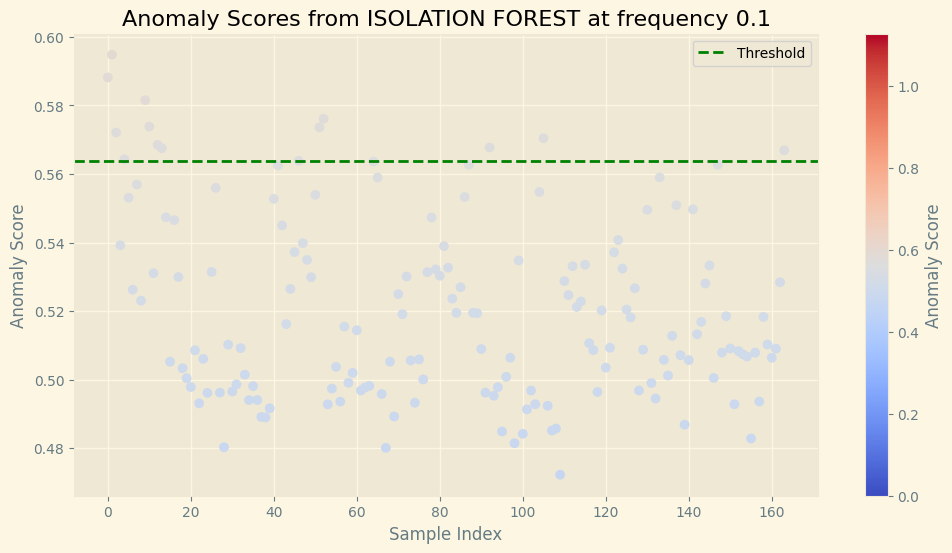

Number of anomalies detected: 14
Threshold: 0.5637
ROC AUC Score: 0.9542
F1 Score: 0.4490
Accuracy: 0.8354
Precision: 0.7857
Recall: 0.3143
              precision    recall  f1-score   support

           0       0.84      0.98      0.90       129
           1       0.79      0.31      0.45        35

    accuracy                           0.84       164
   macro avg       0.81      0.65      0.68       164
weighted avg       0.83      0.84      0.81       164



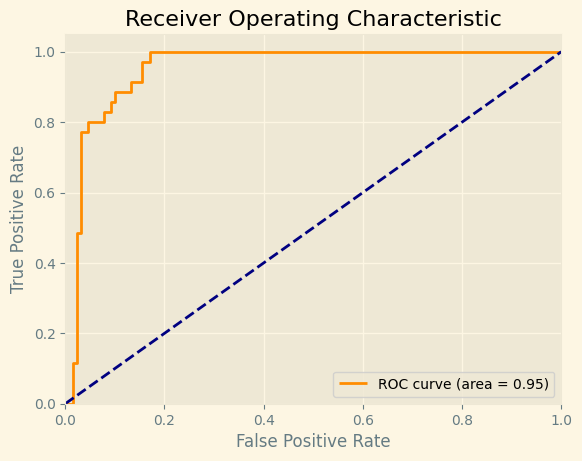

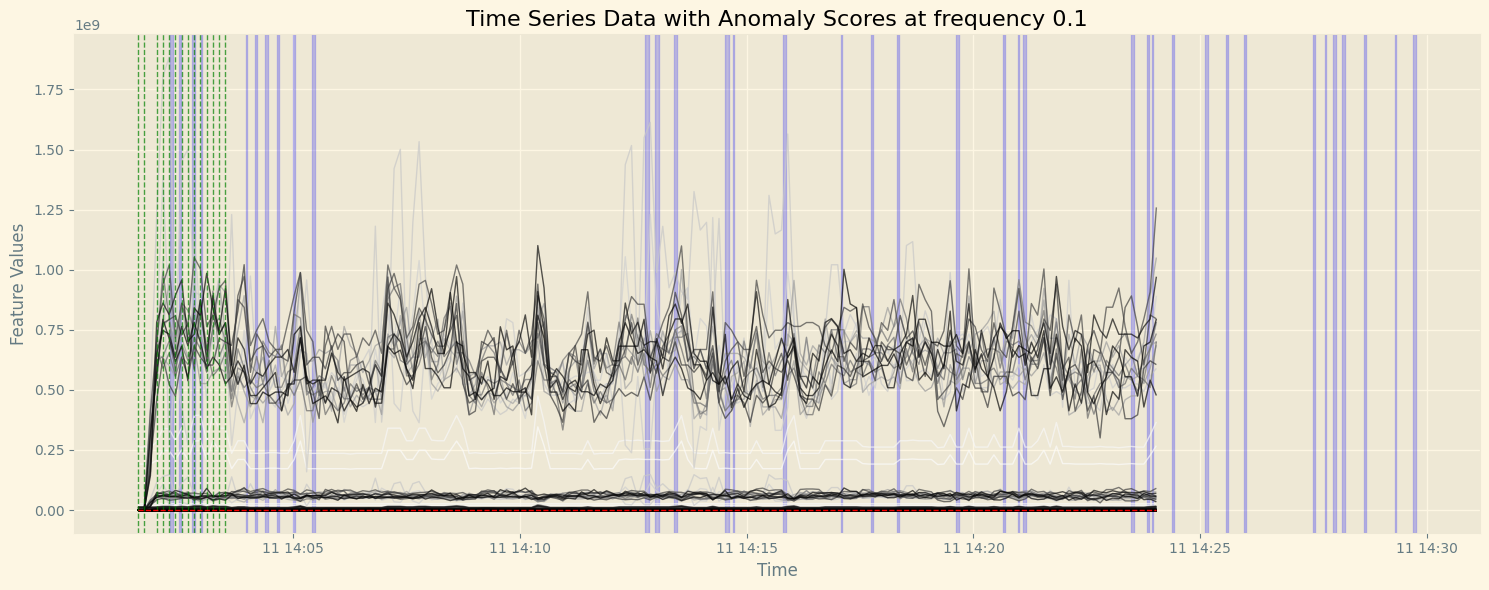

Top 14 Anomalies:
                timestamp  anomaly_score  \
1 2022-08-11 14:01:42.910       0.594786   
0 2022-08-11 14:01:34.644       0.588160   
0 2022-08-11 14:01:59.442       0.588160   
0 2022-08-11 14:02:07.708       0.588160   
0 2022-08-11 14:02:15.974       0.588160   
0 2022-08-11 14:02:24.240       0.588160   
0 2022-08-11 14:02:32.506       0.588160   
0 2022-08-11 14:02:40.772       0.588160   
0 2022-08-11 14:02:49.038       0.588160   
0 2022-08-11 14:02:57.304       0.588160   
0 2022-08-11 14:03:05.570       0.588160   
0 2022-08-11 14:03:13.836       0.588160   
0 2022-08-11 14:03:22.102       0.588160   
0 2022-08-11 14:03:30.368       0.588160   

   machine_nameKuka Robot_apparent_power-_Absolute energy  \
1                                       2.723880e+06        
0                                       2.731075e+06        
0                                       5.401697e+06        
0                                       6.059524e+06        
0               

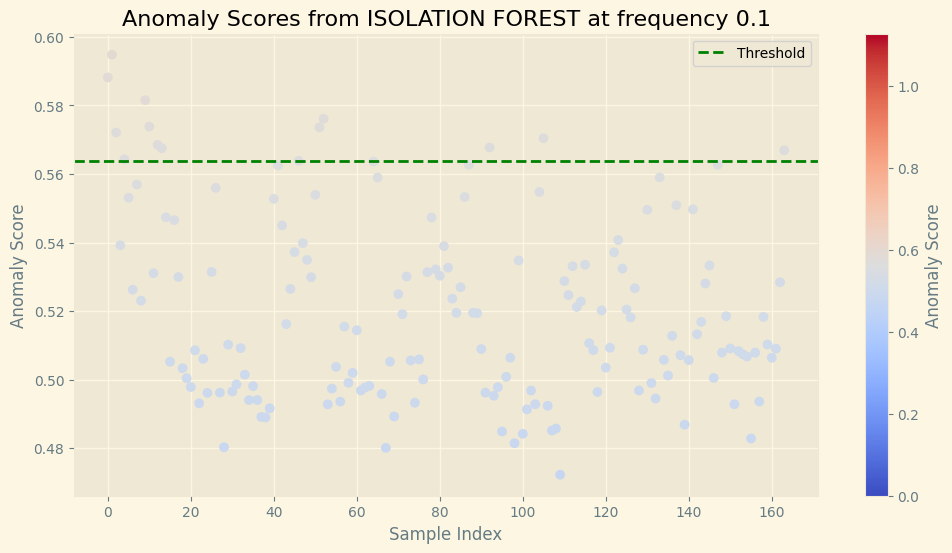

Number of anomalies detected: 14
Threshold: 0.5637
ROC AUC Score: 0.9542
F1 Score: 0.4490
Accuracy: 0.8354
Precision: 0.7857
Recall: 0.3143
              precision    recall  f1-score   support

           0       0.84      0.98      0.90       129
           1       0.79      0.31      0.45        35

    accuracy                           0.84       164
   macro avg       0.81      0.65      0.68       164
weighted avg       0.83      0.84      0.81       164



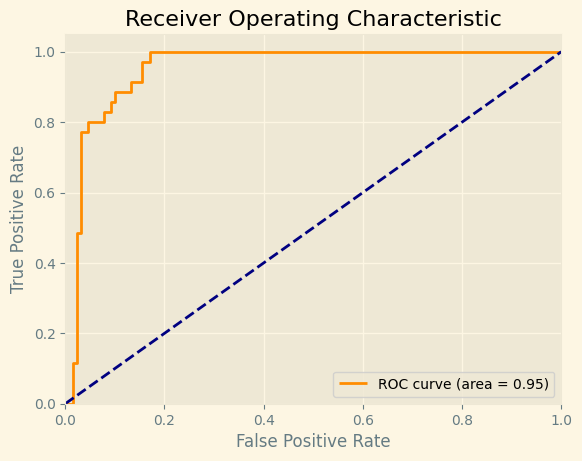

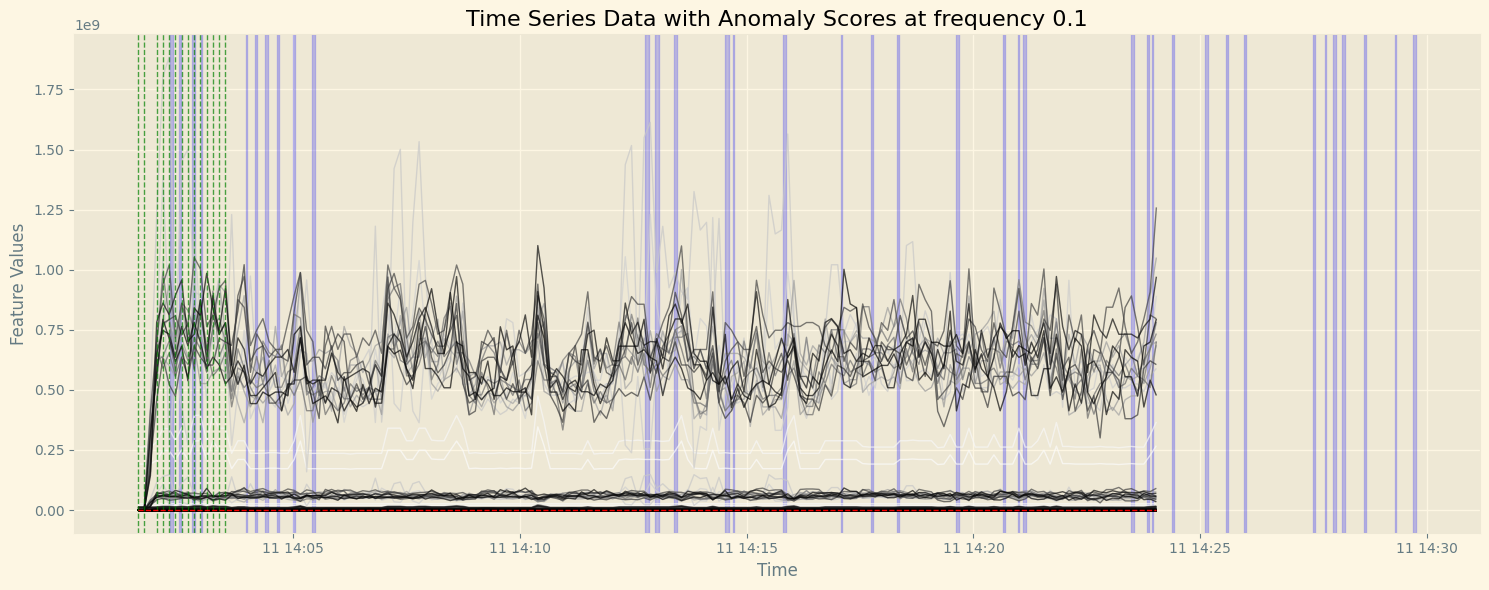

Top 14 Anomalies:
                timestamp  anomaly_score  \
1 2022-08-11 14:01:42.910       0.594786   
0 2022-08-11 14:01:34.644       0.588160   
0 2022-08-11 14:01:59.442       0.588160   
0 2022-08-11 14:02:07.708       0.588160   
0 2022-08-11 14:02:15.974       0.588160   
0 2022-08-11 14:02:24.240       0.588160   
0 2022-08-11 14:02:32.506       0.588160   
0 2022-08-11 14:02:40.772       0.588160   
0 2022-08-11 14:02:49.038       0.588160   
0 2022-08-11 14:02:57.304       0.588160   
0 2022-08-11 14:03:05.570       0.588160   
0 2022-08-11 14:03:13.836       0.588160   
0 2022-08-11 14:03:22.102       0.588160   
0 2022-08-11 14:03:30.368       0.588160   

   machine_nameKuka Robot_apparent_power-_Absolute energy  \
1                                       2.723880e+06        
0                                       2.731075e+06        
0                                       5.401697e+06        
0                                       6.059524e+06        
0               

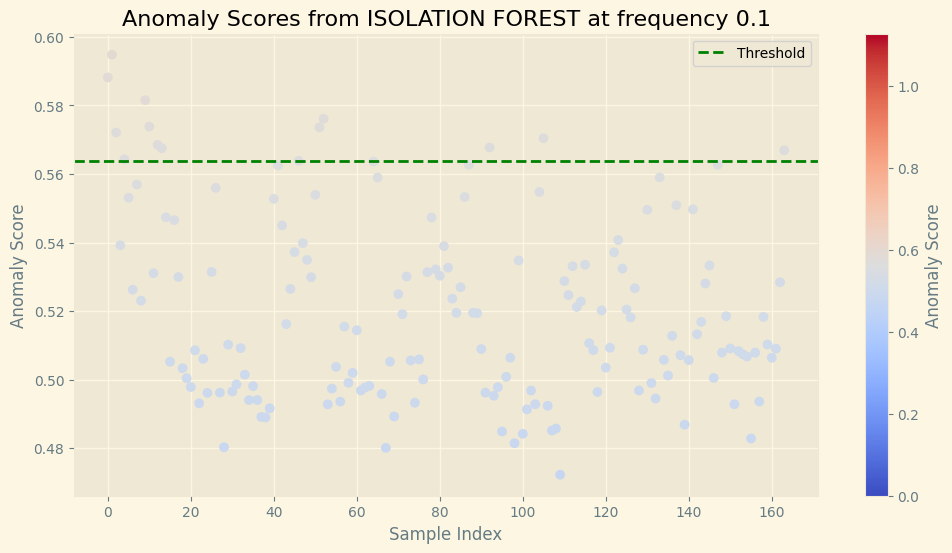

Number of anomalies detected: 14
Threshold: 0.5637
ROC AUC Score: 0.9542
F1 Score: 0.4490
Accuracy: 0.8354
Precision: 0.7857
Recall: 0.3143
              precision    recall  f1-score   support

           0       0.84      0.98      0.90       129
           1       0.79      0.31      0.45        35

    accuracy                           0.84       164
   macro avg       0.81      0.65      0.68       164
weighted avg       0.83      0.84      0.81       164



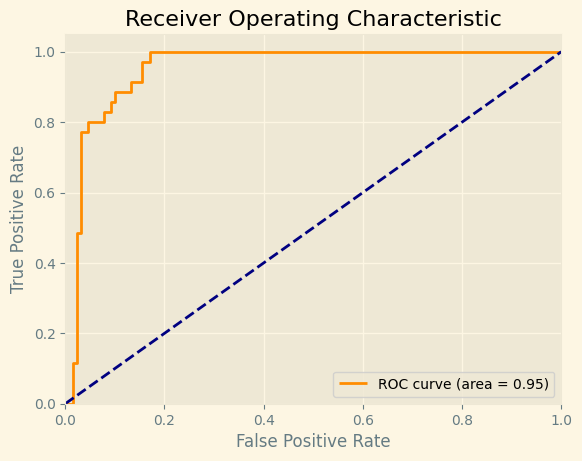

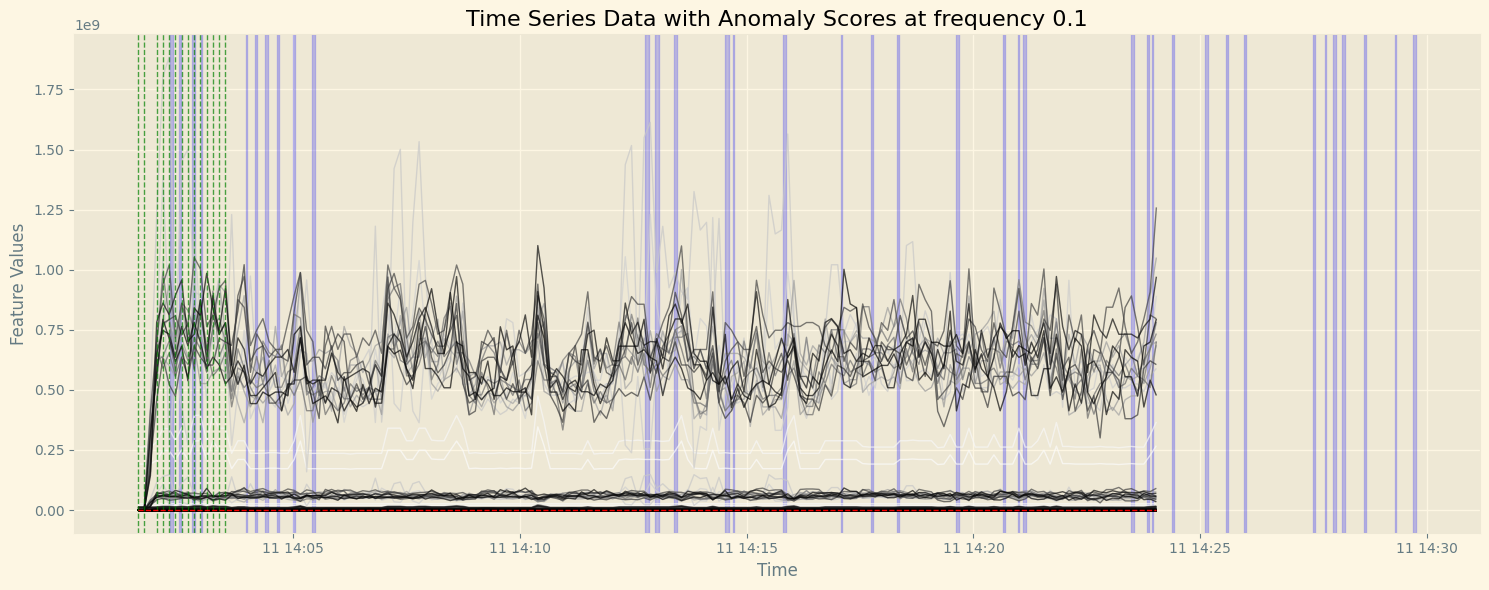

Top 14 Anomalies:
                timestamp  anomaly_score  \
1 2022-08-11 14:01:42.910       0.594786   
0 2022-08-11 14:01:34.644       0.588160   
0 2022-08-11 14:01:59.442       0.588160   
0 2022-08-11 14:02:07.708       0.588160   
0 2022-08-11 14:02:15.974       0.588160   
0 2022-08-11 14:02:24.240       0.588160   
0 2022-08-11 14:02:32.506       0.588160   
0 2022-08-11 14:02:40.772       0.588160   
0 2022-08-11 14:02:49.038       0.588160   
0 2022-08-11 14:02:57.304       0.588160   
0 2022-08-11 14:03:05.570       0.588160   
0 2022-08-11 14:03:13.836       0.588160   
0 2022-08-11 14:03:22.102       0.588160   
0 2022-08-11 14:03:30.368       0.588160   

   machine_nameKuka Robot_apparent_power-_Absolute energy  \
1                                       2.723880e+06        
0                                       2.731075e+06        
0                                       5.401697e+06        
0                                       6.059524e+06        
0               

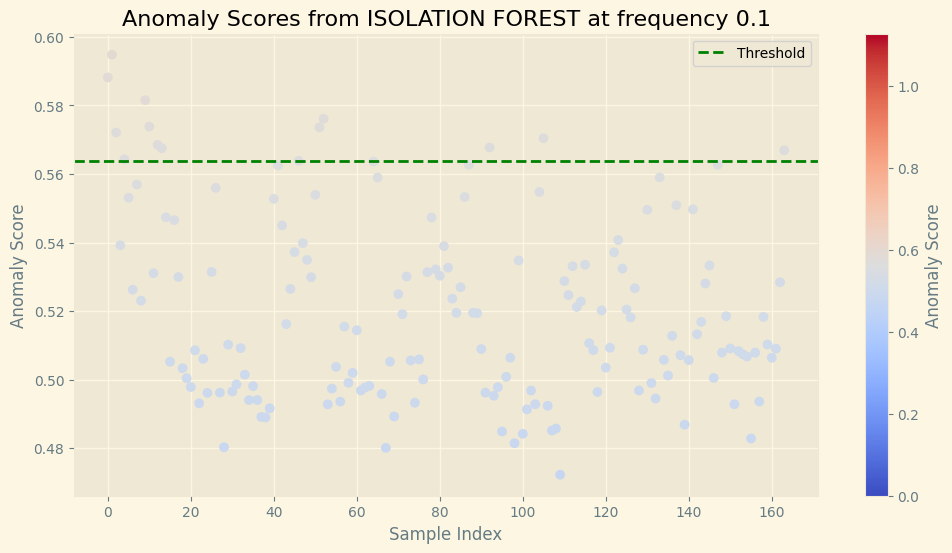

Number of anomalies detected: 14
Threshold: 0.5637
ROC AUC Score: 0.9542
F1 Score: 0.4490
Accuracy: 0.8354
Precision: 0.7857
Recall: 0.3143
              precision    recall  f1-score   support

           0       0.84      0.98      0.90       129
           1       0.79      0.31      0.45        35

    accuracy                           0.84       164
   macro avg       0.81      0.65      0.68       164
weighted avg       0.83      0.84      0.81       164



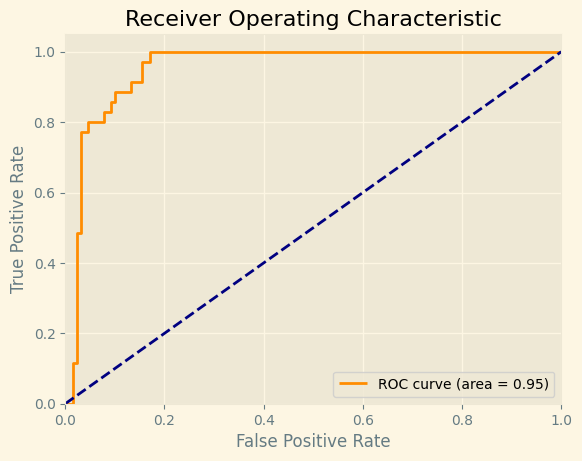

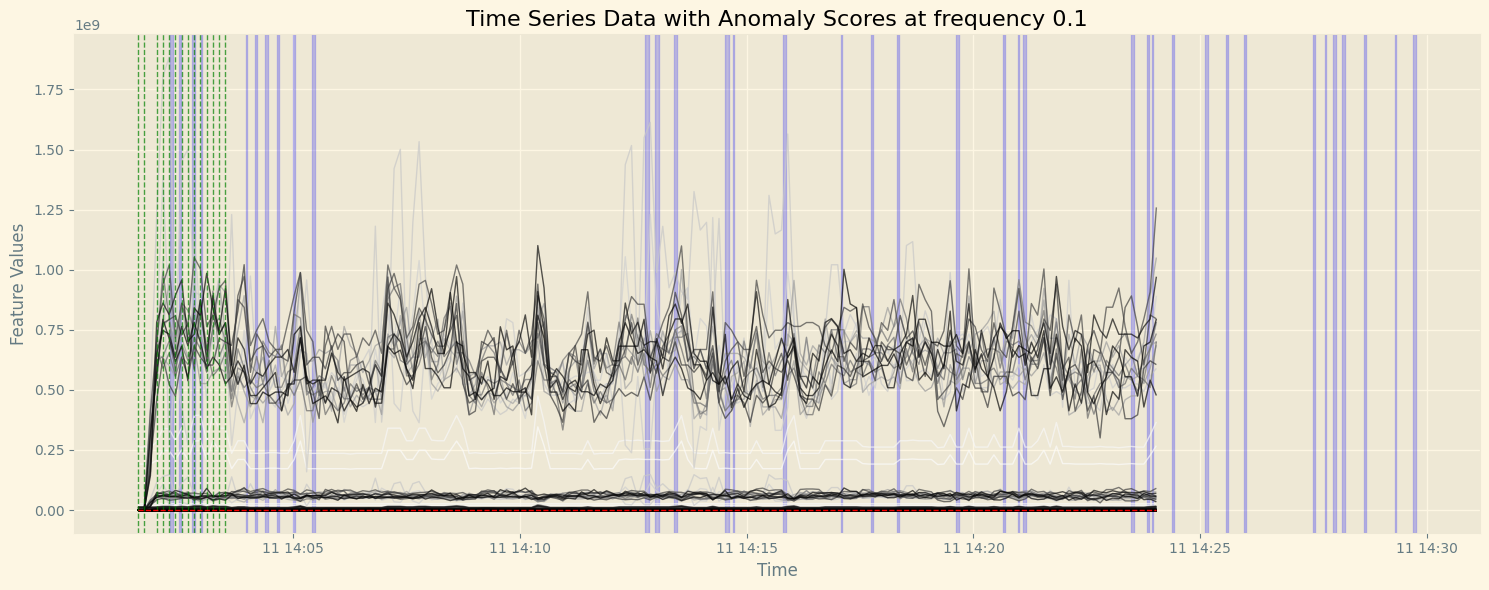

Top 14 Anomalies:
                timestamp  anomaly_score  \
1 2022-08-11 14:01:42.910       0.594786   
0 2022-08-11 14:01:34.644       0.588160   
0 2022-08-11 14:01:59.442       0.588160   
0 2022-08-11 14:02:07.708       0.588160   
0 2022-08-11 14:02:15.974       0.588160   
0 2022-08-11 14:02:24.240       0.588160   
0 2022-08-11 14:02:32.506       0.588160   
0 2022-08-11 14:02:40.772       0.588160   
0 2022-08-11 14:02:49.038       0.588160   
0 2022-08-11 14:02:57.304       0.588160   
0 2022-08-11 14:03:05.570       0.588160   
0 2022-08-11 14:03:13.836       0.588160   
0 2022-08-11 14:03:22.102       0.588160   
0 2022-08-11 14:03:30.368       0.588160   

   machine_nameKuka Robot_apparent_power-_Absolute energy  \
1                                       2.723880e+06        
0                                       2.731075e+06        
0                                       5.401697e+06        
0                                       6.059524e+06        
0               

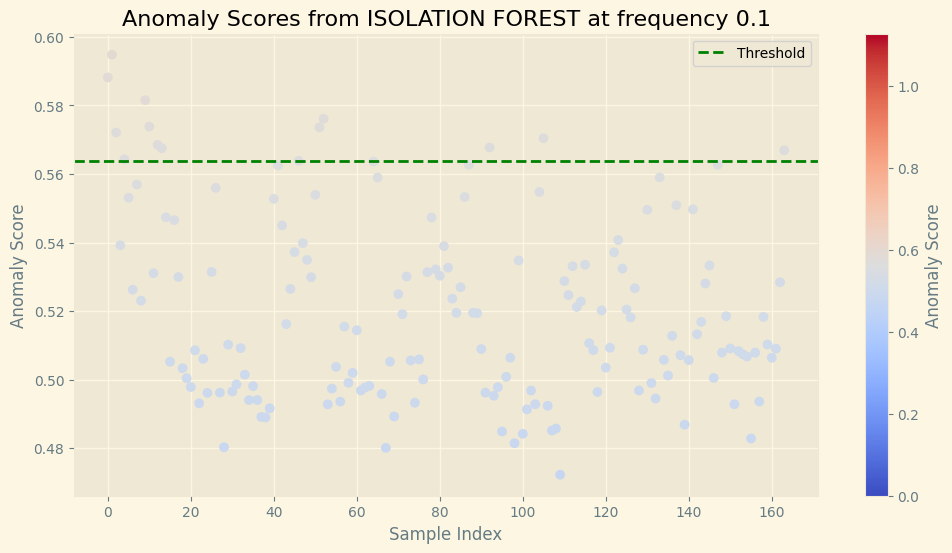

Number of anomalies detected: 14
Threshold: 0.5637
ROC AUC Score: 0.9542
F1 Score: 0.4490
Accuracy: 0.8354
Precision: 0.7857
Recall: 0.3143
              precision    recall  f1-score   support

           0       0.84      0.98      0.90       129
           1       0.79      0.31      0.45        35

    accuracy                           0.84       164
   macro avg       0.81      0.65      0.68       164
weighted avg       0.83      0.84      0.81       164



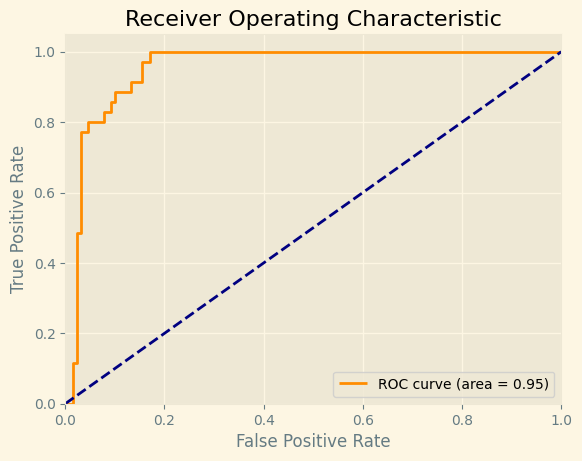

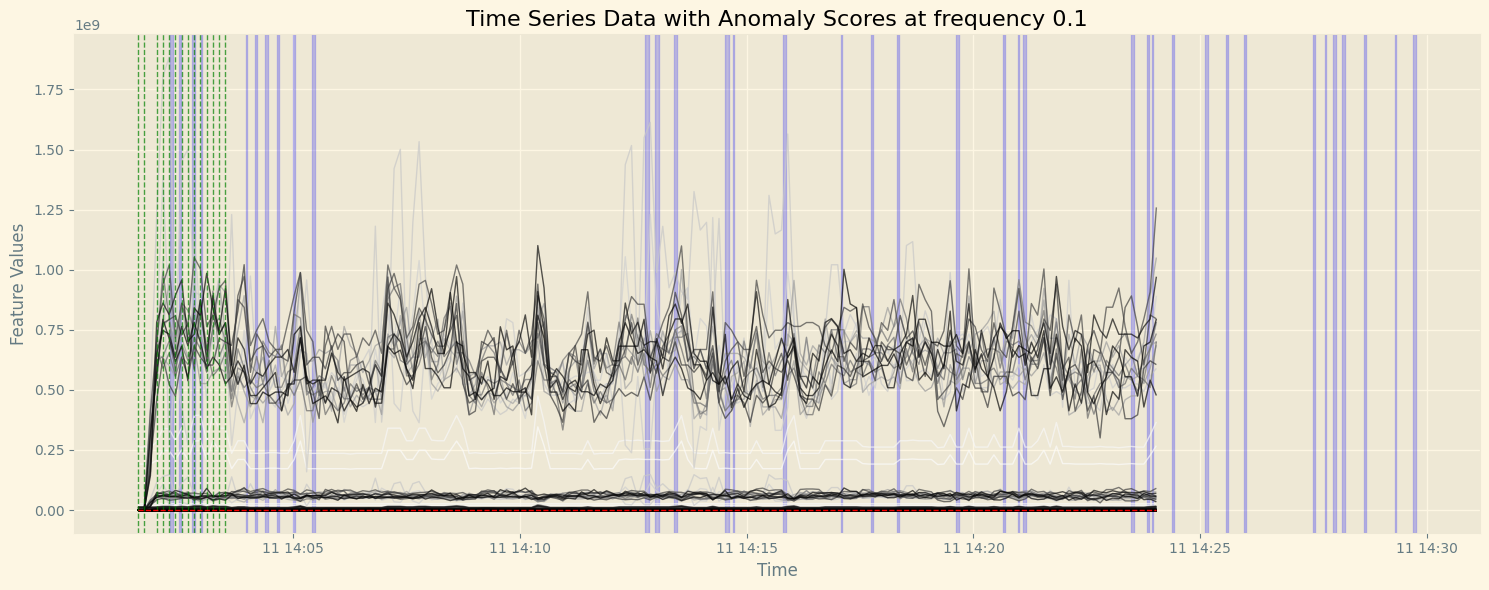

Top 14 Anomalies:
                timestamp  anomaly_score  \
1 2022-08-11 14:01:42.910       0.594786   
0 2022-08-11 14:01:34.644       0.588160   
0 2022-08-11 14:01:59.442       0.588160   
0 2022-08-11 14:02:07.708       0.588160   
0 2022-08-11 14:02:15.974       0.588160   
0 2022-08-11 14:02:24.240       0.588160   
0 2022-08-11 14:02:32.506       0.588160   
0 2022-08-11 14:02:40.772       0.588160   
0 2022-08-11 14:02:49.038       0.588160   
0 2022-08-11 14:02:57.304       0.588160   
0 2022-08-11 14:03:05.570       0.588160   
0 2022-08-11 14:03:13.836       0.588160   
0 2022-08-11 14:03:22.102       0.588160   
0 2022-08-11 14:03:30.368       0.588160   

   machine_nameKuka Robot_apparent_power-_Absolute energy  \
1                                       2.723880e+06        
0                                       2.731075e+06        
0                                       5.401697e+06        
0                                       6.059524e+06        
0               

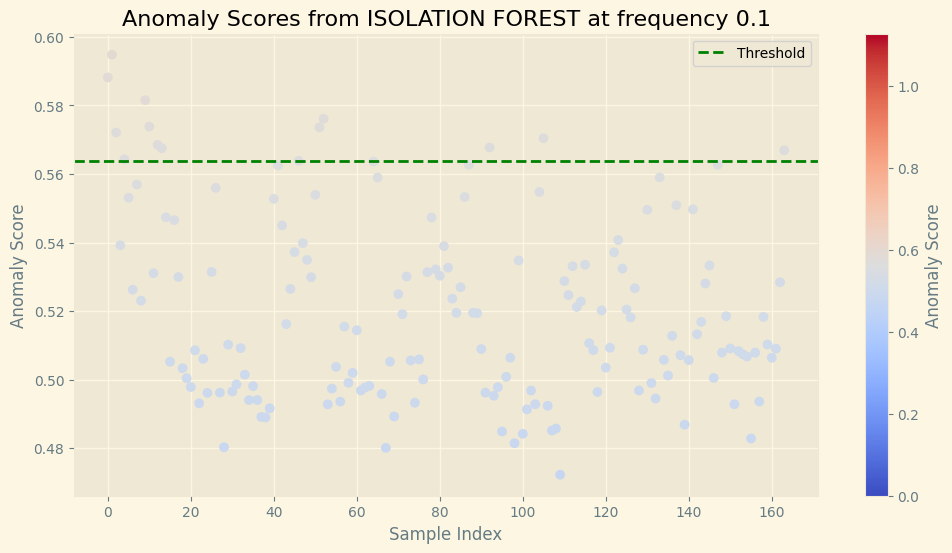

Number of anomalies detected: 14
Threshold: 0.5637
ROC AUC Score: 0.9542
F1 Score: 0.4490
Accuracy: 0.8354
Precision: 0.7857
Recall: 0.3143
              precision    recall  f1-score   support

           0       0.84      0.98      0.90       129
           1       0.79      0.31      0.45        35

    accuracy                           0.84       164
   macro avg       0.81      0.65      0.68       164
weighted avg       0.83      0.84      0.81       164



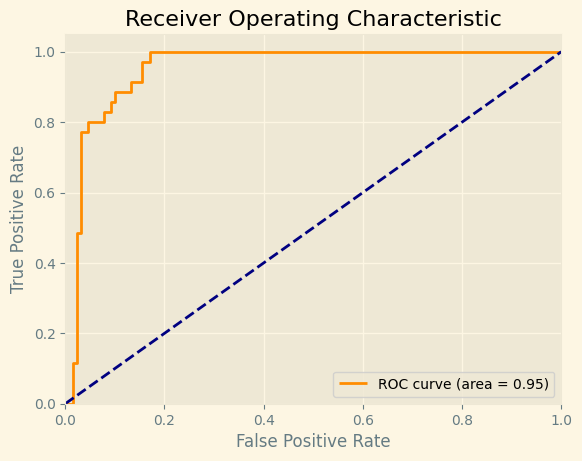

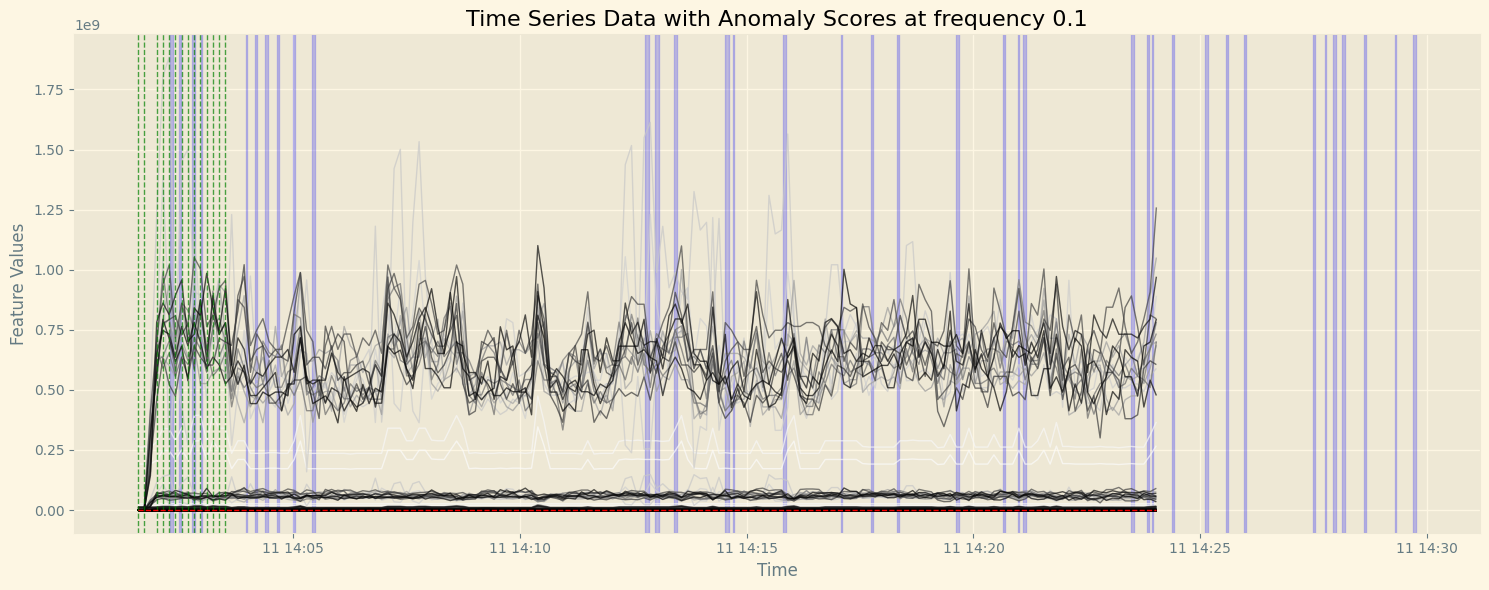

Top 14 Anomalies:
                timestamp  anomaly_score  \
1 2022-08-11 14:01:42.910       0.594786   
0 2022-08-11 14:01:34.644       0.588160   
0 2022-08-11 14:01:59.442       0.588160   
0 2022-08-11 14:02:07.708       0.588160   
0 2022-08-11 14:02:15.974       0.588160   
0 2022-08-11 14:02:24.240       0.588160   
0 2022-08-11 14:02:32.506       0.588160   
0 2022-08-11 14:02:40.772       0.588160   
0 2022-08-11 14:02:49.038       0.588160   
0 2022-08-11 14:02:57.304       0.588160   
0 2022-08-11 14:03:05.570       0.588160   
0 2022-08-11 14:03:13.836       0.588160   
0 2022-08-11 14:03:22.102       0.588160   
0 2022-08-11 14:03:30.368       0.588160   

   machine_nameKuka Robot_apparent_power-_Absolute energy  \
1                                       2.723880e+06        
0                                       2.731075e+06        
0                                       5.401697e+06        
0                                       6.059524e+06        
0               

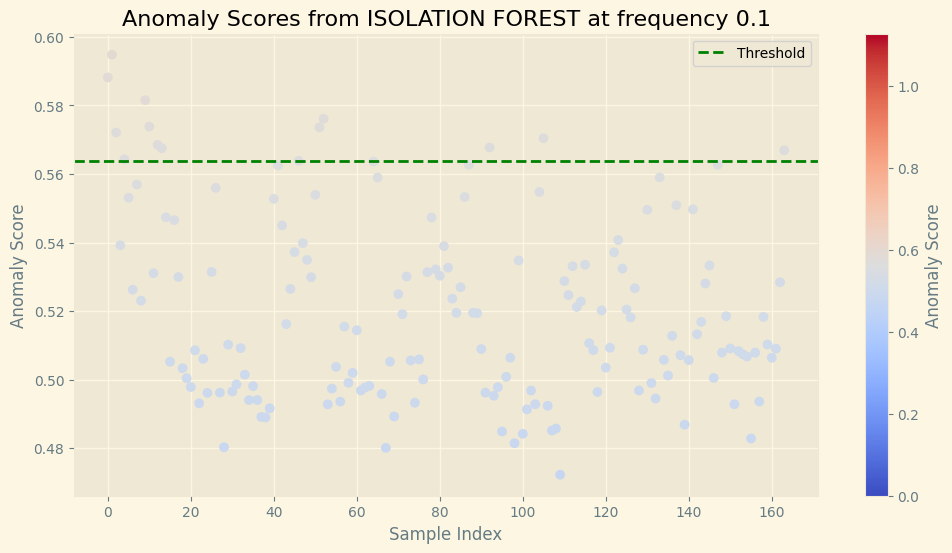

Number of anomalies detected: 14
Threshold: 0.5637
ROC AUC Score: 0.9542
F1 Score: 0.4490
Accuracy: 0.8354
Precision: 0.7857
Recall: 0.3143
              precision    recall  f1-score   support

           0       0.84      0.98      0.90       129
           1       0.79      0.31      0.45        35

    accuracy                           0.84       164
   macro avg       0.81      0.65      0.68       164
weighted avg       0.83      0.84      0.81       164



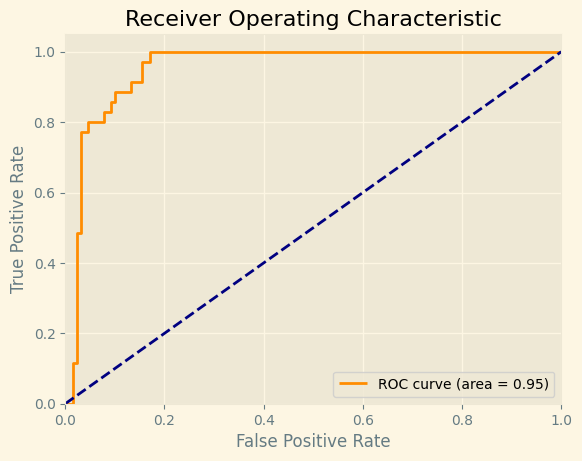

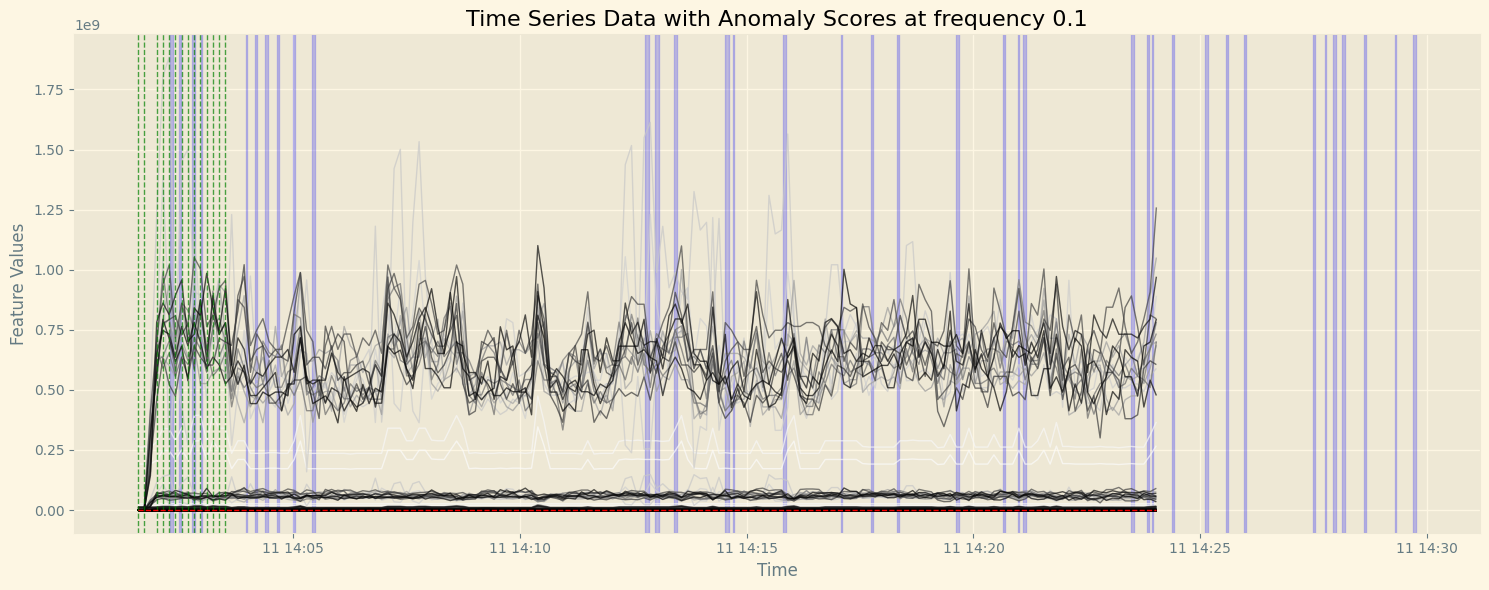

Top 14 Anomalies:
                timestamp  anomaly_score  \
1 2022-08-11 14:01:42.910       0.594786   
0 2022-08-11 14:01:34.644       0.588160   
0 2022-08-11 14:01:59.442       0.588160   
0 2022-08-11 14:02:07.708       0.588160   
0 2022-08-11 14:02:15.974       0.588160   
0 2022-08-11 14:02:24.240       0.588160   
0 2022-08-11 14:02:32.506       0.588160   
0 2022-08-11 14:02:40.772       0.588160   
0 2022-08-11 14:02:49.038       0.588160   
0 2022-08-11 14:02:57.304       0.588160   
0 2022-08-11 14:03:05.570       0.588160   
0 2022-08-11 14:03:13.836       0.588160   
0 2022-08-11 14:03:22.102       0.588160   
0 2022-08-11 14:03:30.368       0.588160   

   machine_nameKuka Robot_apparent_power-_Absolute energy  \
1                                       2.723880e+06        
0                                       2.731075e+06        
0                                       5.401697e+06        
0                                       6.059524e+06        
0               

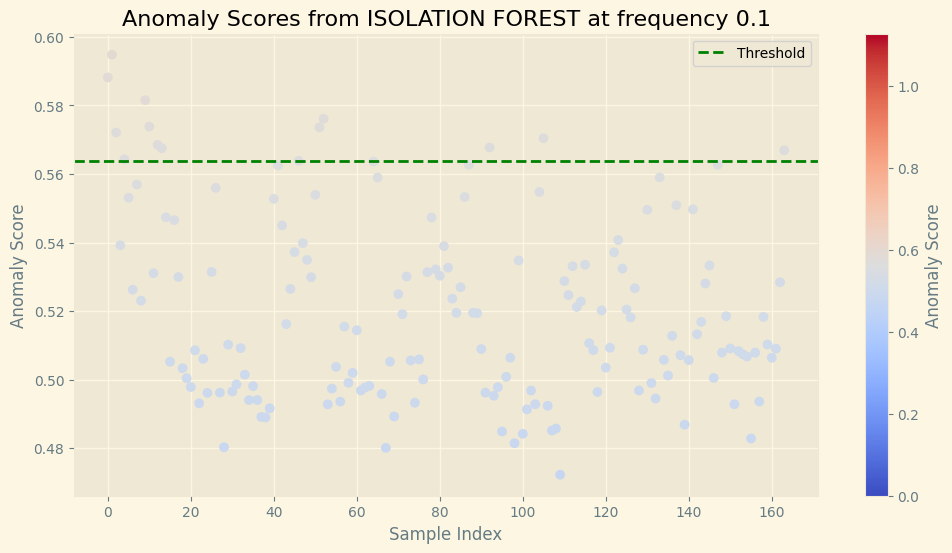

Number of anomalies detected: 14
Threshold: 0.5637
ROC AUC Score: 0.9542
F1 Score: 0.4490
Accuracy: 0.8354
Precision: 0.7857
Recall: 0.3143
              precision    recall  f1-score   support

           0       0.84      0.98      0.90       129
           1       0.79      0.31      0.45        35

    accuracy                           0.84       164
   macro avg       0.81      0.65      0.68       164
weighted avg       0.83      0.84      0.81       164



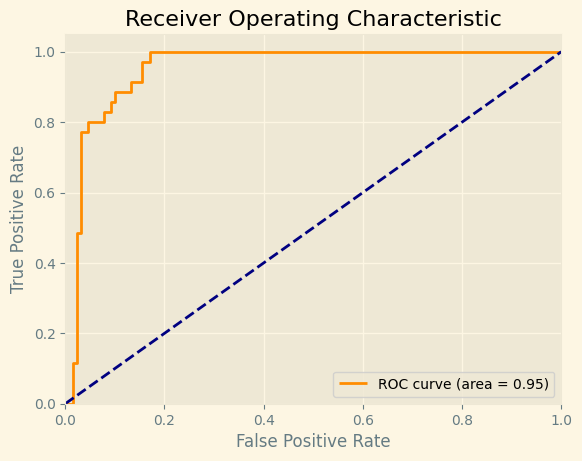

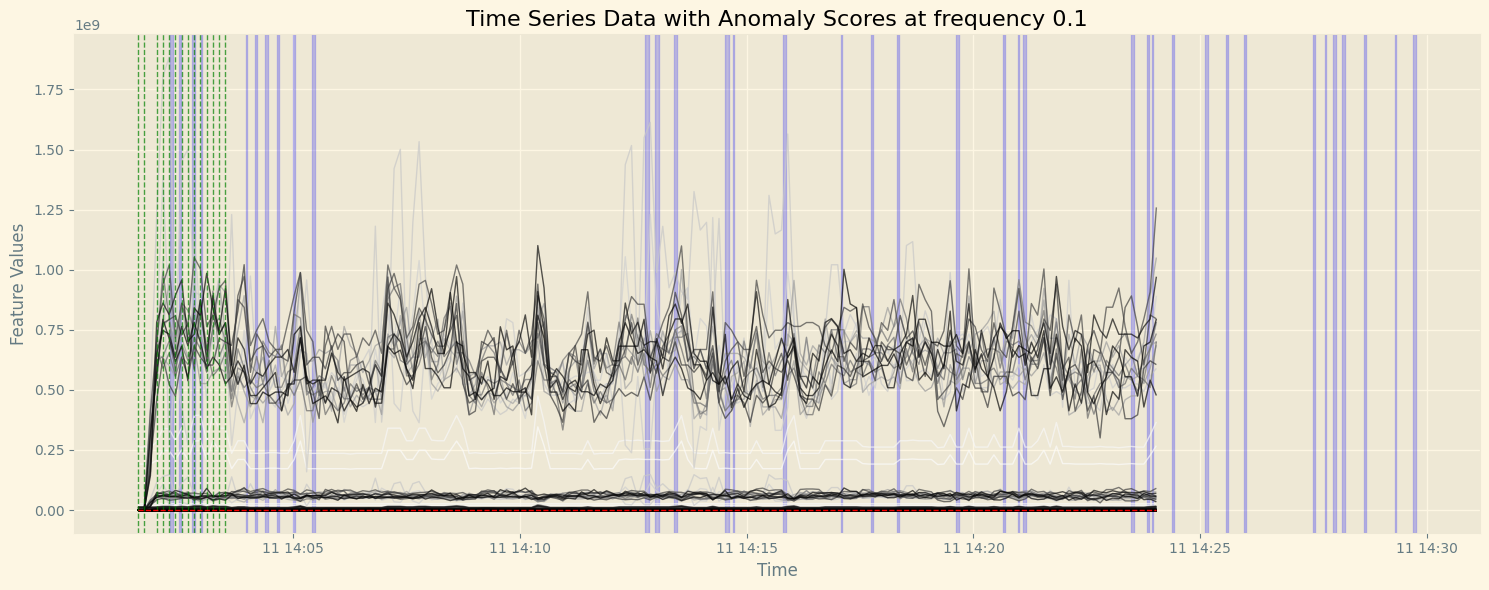

Top 14 Anomalies:
                timestamp  anomaly_score  \
1 2022-08-11 14:01:42.910       0.594786   
0 2022-08-11 14:01:34.644       0.588160   
0 2022-08-11 14:01:59.442       0.588160   
0 2022-08-11 14:02:07.708       0.588160   
0 2022-08-11 14:02:15.974       0.588160   
0 2022-08-11 14:02:24.240       0.588160   
0 2022-08-11 14:02:32.506       0.588160   
0 2022-08-11 14:02:40.772       0.588160   
0 2022-08-11 14:02:49.038       0.588160   
0 2022-08-11 14:02:57.304       0.588160   
0 2022-08-11 14:03:05.570       0.588160   
0 2022-08-11 14:03:13.836       0.588160   
0 2022-08-11 14:03:22.102       0.588160   
0 2022-08-11 14:03:30.368       0.588160   

   machine_nameKuka Robot_apparent_power-_Absolute energy  \
1                                       2.723880e+06        
0                                       2.731075e+06        
0                                       5.401697e+06        
0                                       6.059524e+06        
0               

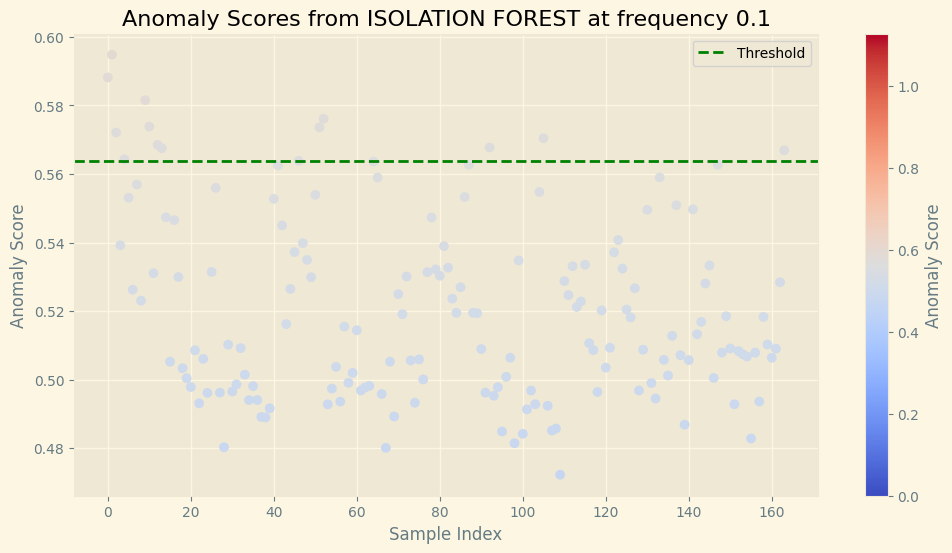

Number of anomalies detected: 14
Threshold: 0.5637
ROC AUC Score: 0.9542
F1 Score: 0.4490
Accuracy: 0.8354
Precision: 0.7857
Recall: 0.3143
              precision    recall  f1-score   support

           0       0.84      0.98      0.90       129
           1       0.79      0.31      0.45        35

    accuracy                           0.84       164
   macro avg       0.81      0.65      0.68       164
weighted avg       0.83      0.84      0.81       164



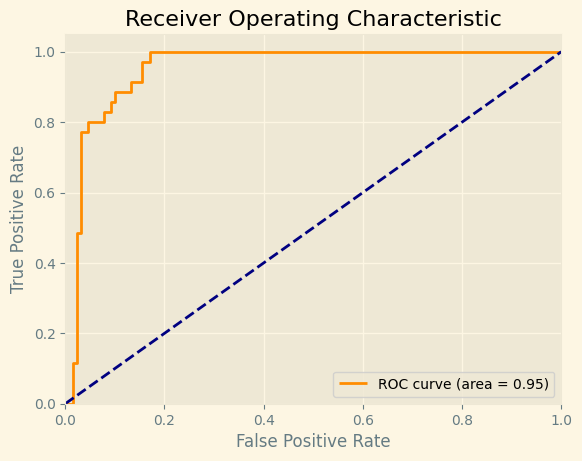

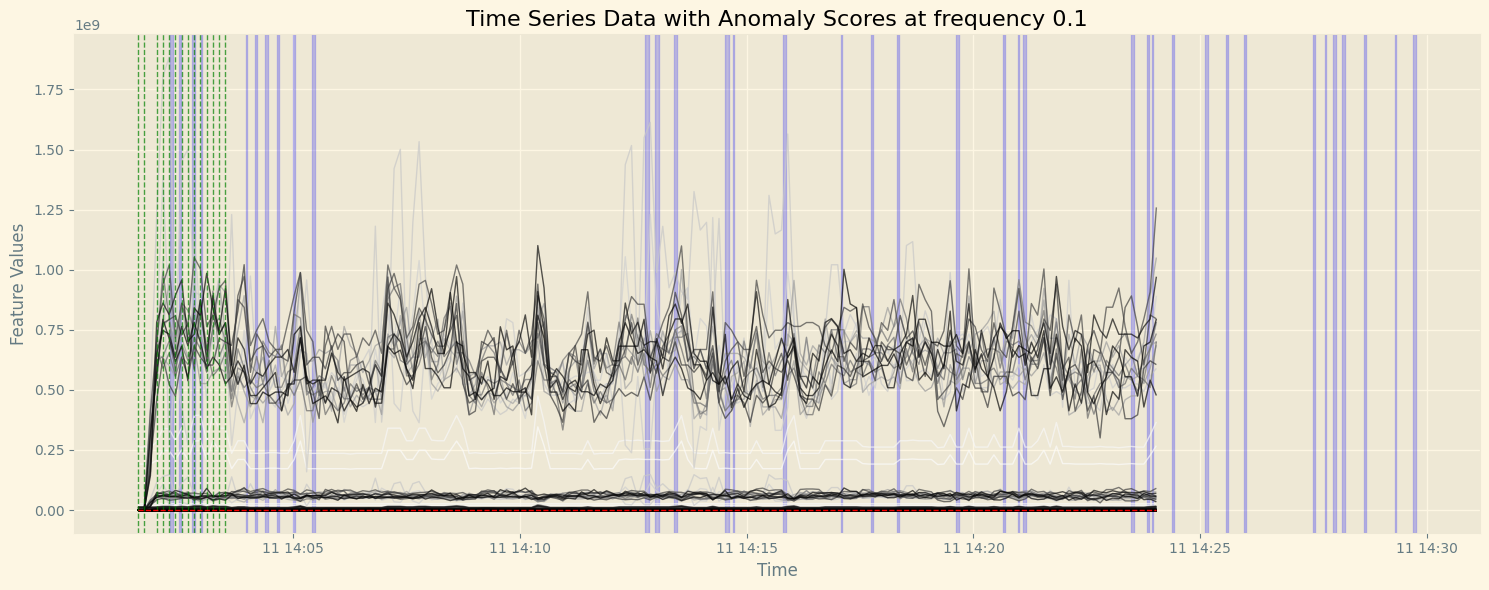

Top 14 Anomalies:
                timestamp  anomaly_score  \
1 2022-08-11 14:01:42.910       0.594786   
0 2022-08-11 14:01:34.644       0.588160   
0 2022-08-11 14:01:59.442       0.588160   
0 2022-08-11 14:02:07.708       0.588160   
0 2022-08-11 14:02:15.974       0.588160   
0 2022-08-11 14:02:24.240       0.588160   
0 2022-08-11 14:02:32.506       0.588160   
0 2022-08-11 14:02:40.772       0.588160   
0 2022-08-11 14:02:49.038       0.588160   
0 2022-08-11 14:02:57.304       0.588160   
0 2022-08-11 14:03:05.570       0.588160   
0 2022-08-11 14:03:13.836       0.588160   
0 2022-08-11 14:03:22.102       0.588160   
0 2022-08-11 14:03:30.368       0.588160   

   machine_nameKuka Robot_apparent_power-_Absolute energy  \
1                                       2.723880e+06        
0                                       2.731075e+06        
0                                       5.401697e+06        
0                                       6.059524e+06        
0               

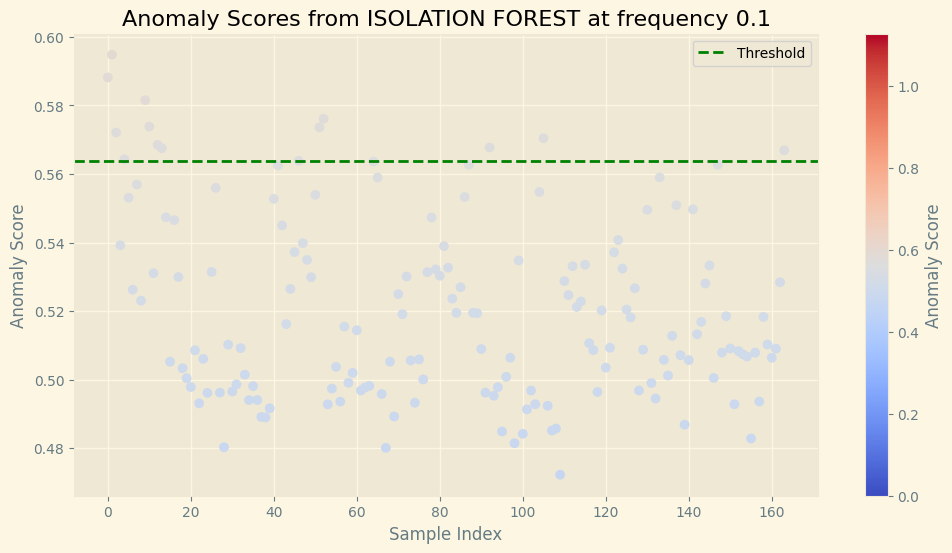

Number of anomalies detected: 14
Threshold: 0.5637
ROC AUC Score: 0.9542
F1 Score: 0.4490
Accuracy: 0.8354
Precision: 0.7857
Recall: 0.3143
              precision    recall  f1-score   support

           0       0.84      0.98      0.90       129
           1       0.79      0.31      0.45        35

    accuracy                           0.84       164
   macro avg       0.81      0.65      0.68       164
weighted avg       0.83      0.84      0.81       164



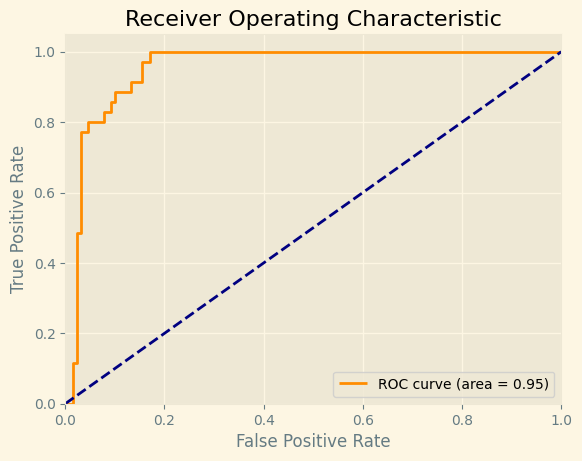

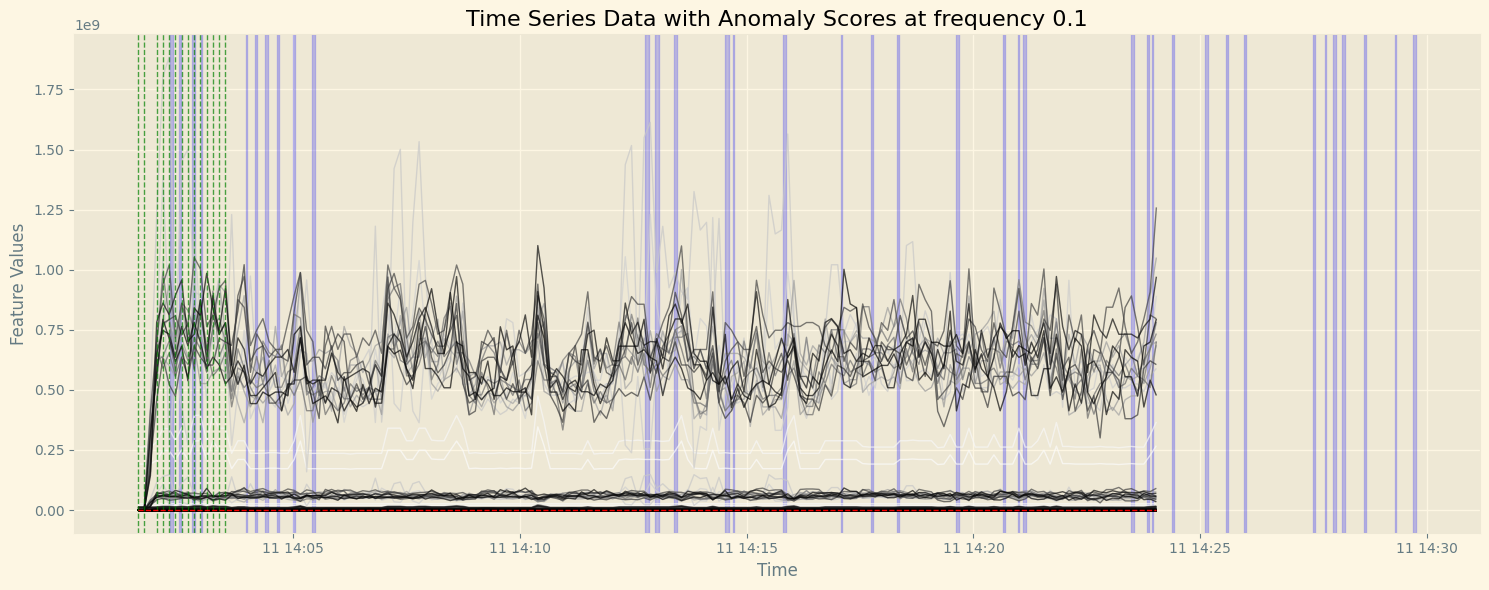

Top 14 Anomalies:
                timestamp  anomaly_score  \
1 2022-08-11 14:01:42.910       0.594786   
0 2022-08-11 14:01:34.644       0.588160   
0 2022-08-11 14:01:59.442       0.588160   
0 2022-08-11 14:02:07.708       0.588160   
0 2022-08-11 14:02:15.974       0.588160   
0 2022-08-11 14:02:24.240       0.588160   
0 2022-08-11 14:02:32.506       0.588160   
0 2022-08-11 14:02:40.772       0.588160   
0 2022-08-11 14:02:49.038       0.588160   
0 2022-08-11 14:02:57.304       0.588160   
0 2022-08-11 14:03:05.570       0.588160   
0 2022-08-11 14:03:13.836       0.588160   
0 2022-08-11 14:03:22.102       0.588160   
0 2022-08-11 14:03:30.368       0.588160   

   machine_nameKuka Robot_apparent_power-_Absolute energy  \
1                                       2.723880e+06        
0                                       2.731075e+06        
0                                       5.401697e+06        
0                                       6.059524e+06        
0               

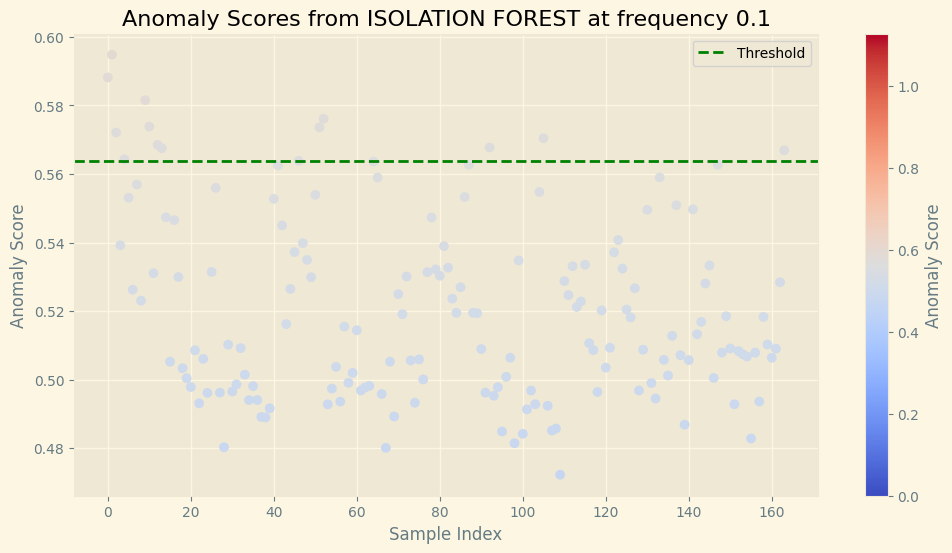

Number of anomalies detected: 14
Threshold: 0.5637
ROC AUC Score: 0.9542
F1 Score: 0.4490
Accuracy: 0.8354
Precision: 0.7857
Recall: 0.3143
              precision    recall  f1-score   support

           0       0.84      0.98      0.90       129
           1       0.79      0.31      0.45        35

    accuracy                           0.84       164
   macro avg       0.81      0.65      0.68       164
weighted avg       0.83      0.84      0.81       164



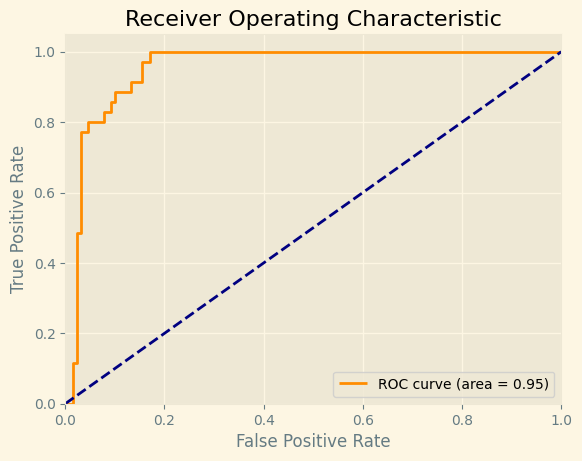

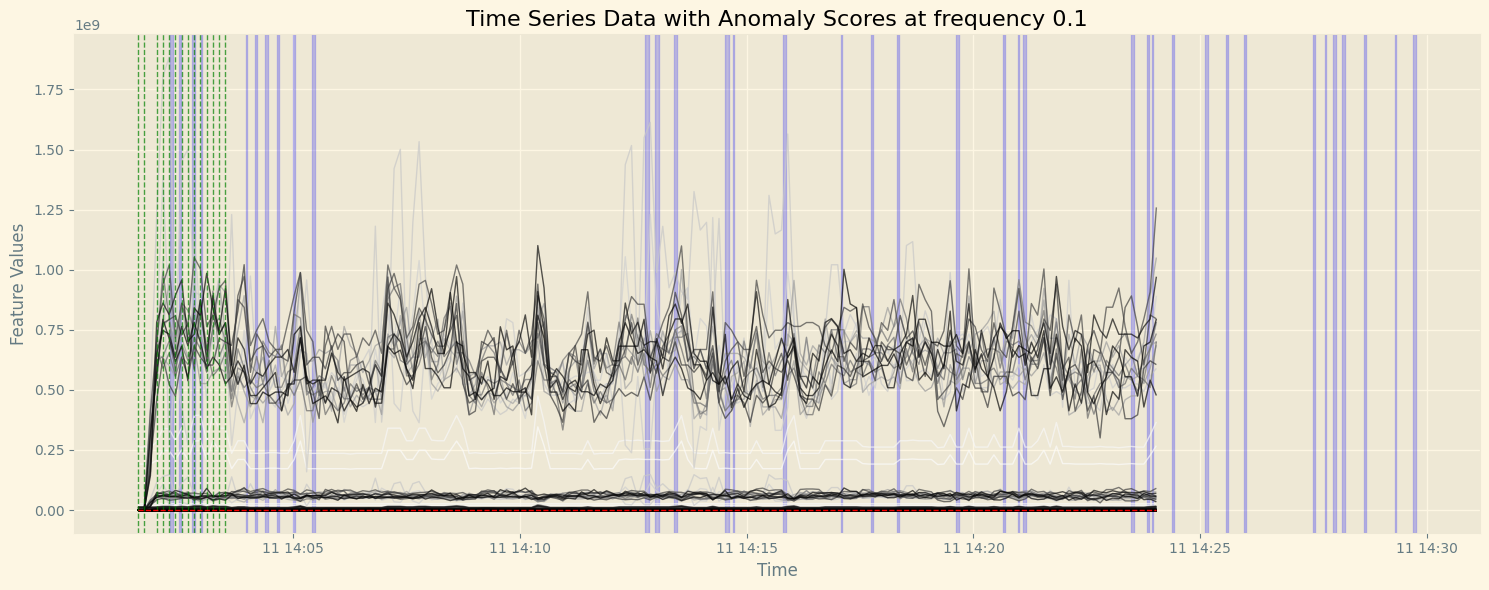

Top 14 Anomalies:
                timestamp  anomaly_score  \
1 2022-08-11 14:01:42.910       0.594786   
0 2022-08-11 14:01:34.644       0.588160   
0 2022-08-11 14:01:59.442       0.588160   
0 2022-08-11 14:02:07.708       0.588160   
0 2022-08-11 14:02:15.974       0.588160   
0 2022-08-11 14:02:24.240       0.588160   
0 2022-08-11 14:02:32.506       0.588160   
0 2022-08-11 14:02:40.772       0.588160   
0 2022-08-11 14:02:49.038       0.588160   
0 2022-08-11 14:02:57.304       0.588160   
0 2022-08-11 14:03:05.570       0.588160   
0 2022-08-11 14:03:13.836       0.588160   
0 2022-08-11 14:03:22.102       0.588160   
0 2022-08-11 14:03:30.368       0.588160   

   machine_nameKuka Robot_apparent_power-_Absolute energy  \
1                                       2.723880e+06        
0                                       2.731075e+06        
0                                       5.401697e+06        
0                                       6.059524e+06        
0               

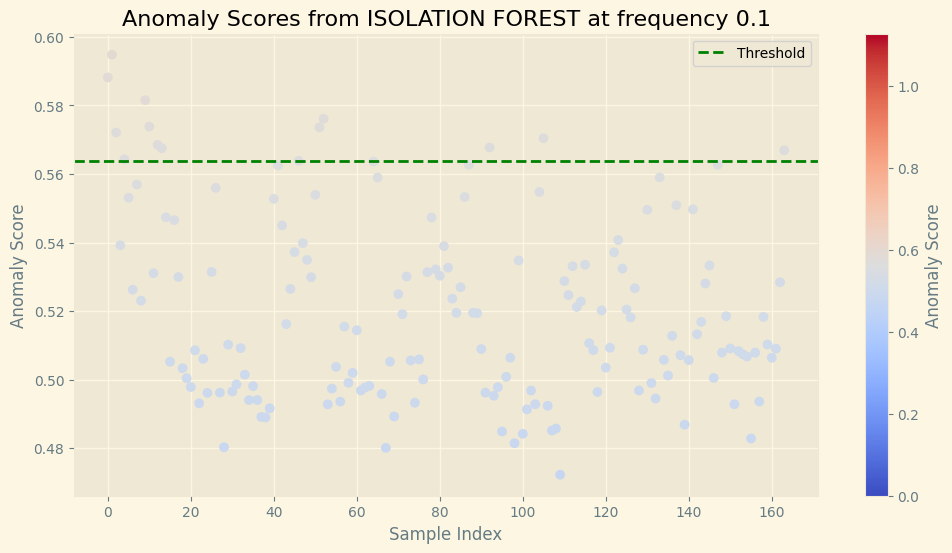

Number of anomalies detected: 14
Threshold: 0.5637
ROC AUC Score: 0.9542
F1 Score: 0.4490
Accuracy: 0.8354
Precision: 0.7857
Recall: 0.3143
              precision    recall  f1-score   support

           0       0.84      0.98      0.90       129
           1       0.79      0.31      0.45        35

    accuracy                           0.84       164
   macro avg       0.81      0.65      0.68       164
weighted avg       0.83      0.84      0.81       164



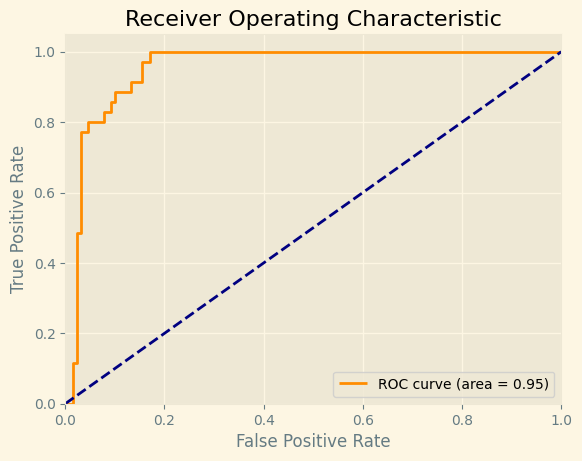

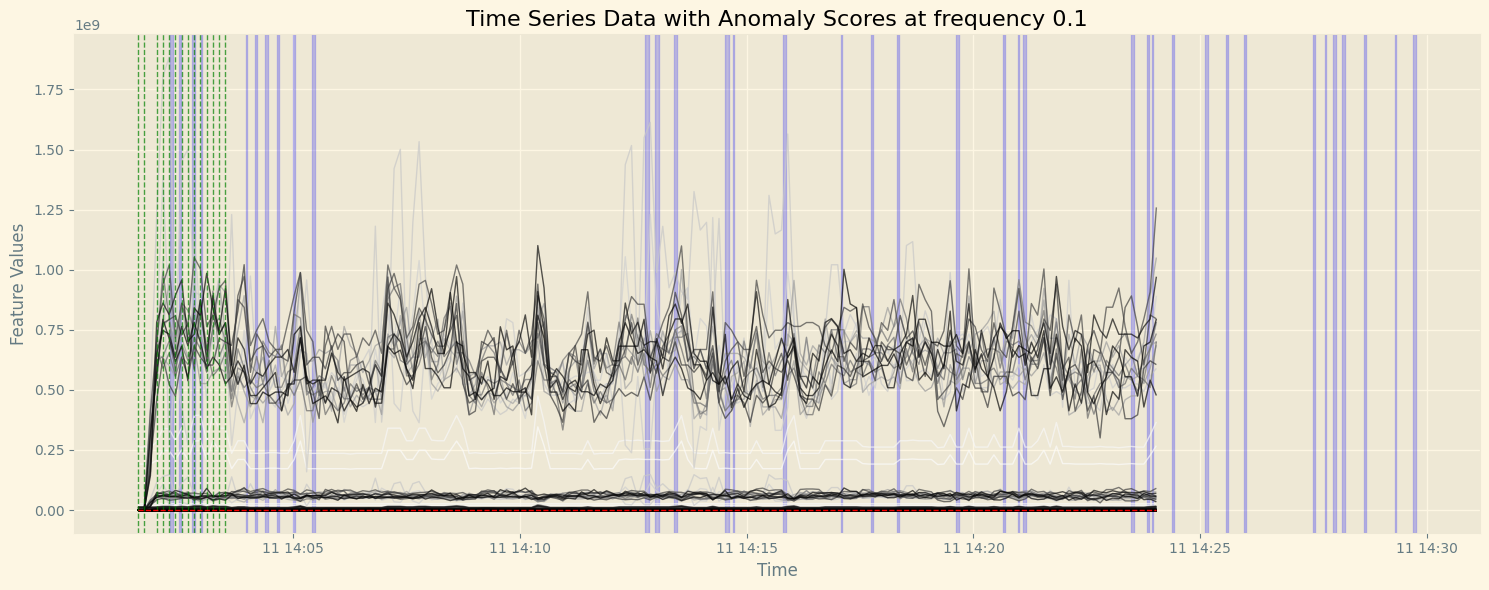

Top 14 Anomalies:
                timestamp  anomaly_score  \
1 2022-08-11 14:01:42.910       0.594786   
0 2022-08-11 14:01:34.644       0.588160   
0 2022-08-11 14:01:59.442       0.588160   
0 2022-08-11 14:02:07.708       0.588160   
0 2022-08-11 14:02:15.974       0.588160   
0 2022-08-11 14:02:24.240       0.588160   
0 2022-08-11 14:02:32.506       0.588160   
0 2022-08-11 14:02:40.772       0.588160   
0 2022-08-11 14:02:49.038       0.588160   
0 2022-08-11 14:02:57.304       0.588160   
0 2022-08-11 14:03:05.570       0.588160   
0 2022-08-11 14:03:13.836       0.588160   
0 2022-08-11 14:03:22.102       0.588160   
0 2022-08-11 14:03:30.368       0.588160   

   machine_nameKuka Robot_apparent_power-_Absolute energy  \
1                                       2.723880e+06        
0                                       2.731075e+06        
0                                       5.401697e+06        
0                                       6.059524e+06        
0               

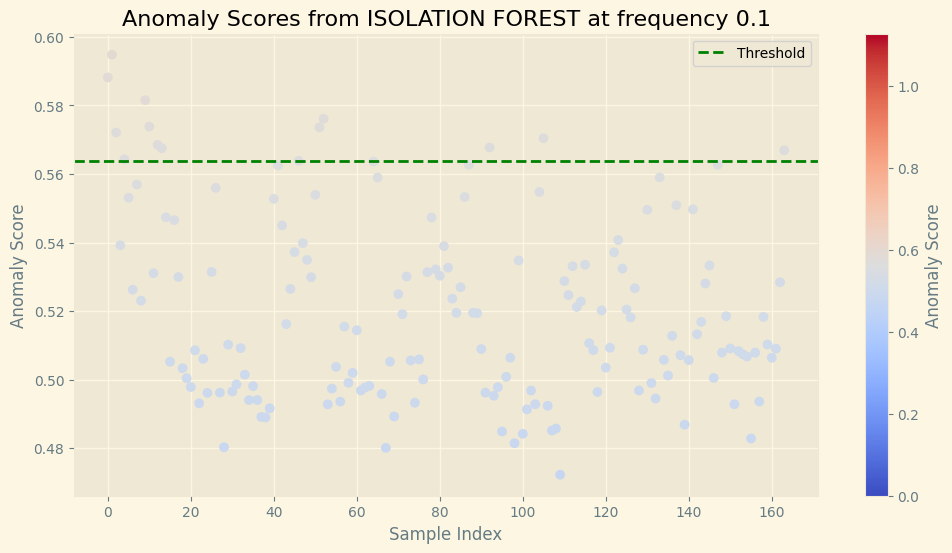

Number of anomalies detected: 14
Threshold: 0.5637
ROC AUC Score: 0.9542
F1 Score: 0.4490
Accuracy: 0.8354
Precision: 0.7857
Recall: 0.3143
              precision    recall  f1-score   support

           0       0.84      0.98      0.90       129
           1       0.79      0.31      0.45        35

    accuracy                           0.84       164
   macro avg       0.81      0.65      0.68       164
weighted avg       0.83      0.84      0.81       164



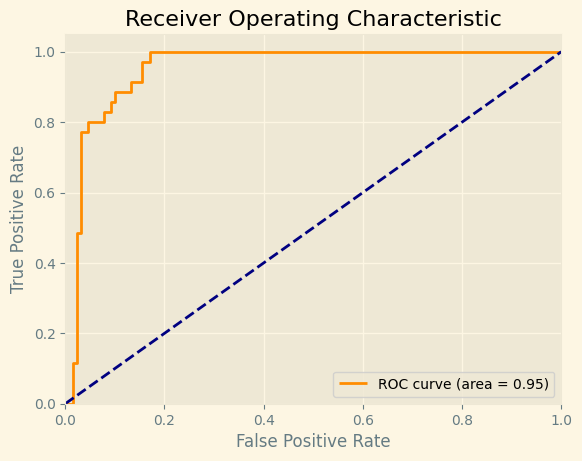

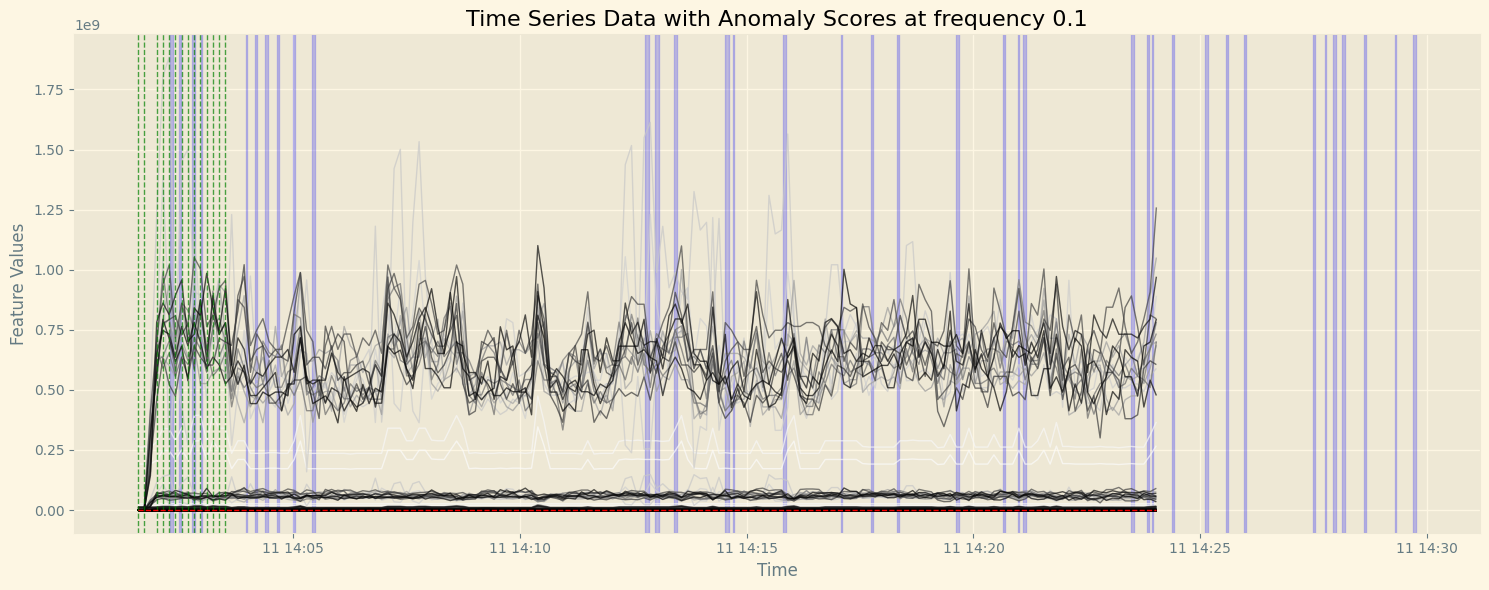

Top 14 Anomalies:
                timestamp  anomaly_score  \
1 2022-08-11 14:01:42.910       0.594786   
0 2022-08-11 14:01:34.644       0.588160   
0 2022-08-11 14:01:59.442       0.588160   
0 2022-08-11 14:02:07.708       0.588160   
0 2022-08-11 14:02:15.974       0.588160   
0 2022-08-11 14:02:24.240       0.588160   
0 2022-08-11 14:02:32.506       0.588160   
0 2022-08-11 14:02:40.772       0.588160   
0 2022-08-11 14:02:49.038       0.588160   
0 2022-08-11 14:02:57.304       0.588160   
0 2022-08-11 14:03:05.570       0.588160   
0 2022-08-11 14:03:13.836       0.588160   
0 2022-08-11 14:03:22.102       0.588160   
0 2022-08-11 14:03:30.368       0.588160   

   machine_nameKuka Robot_apparent_power-_Absolute energy  \
1                                       2.723880e+06        
0                                       2.731075e+06        
0                                       5.401697e+06        
0                                       6.059524e+06        
0               

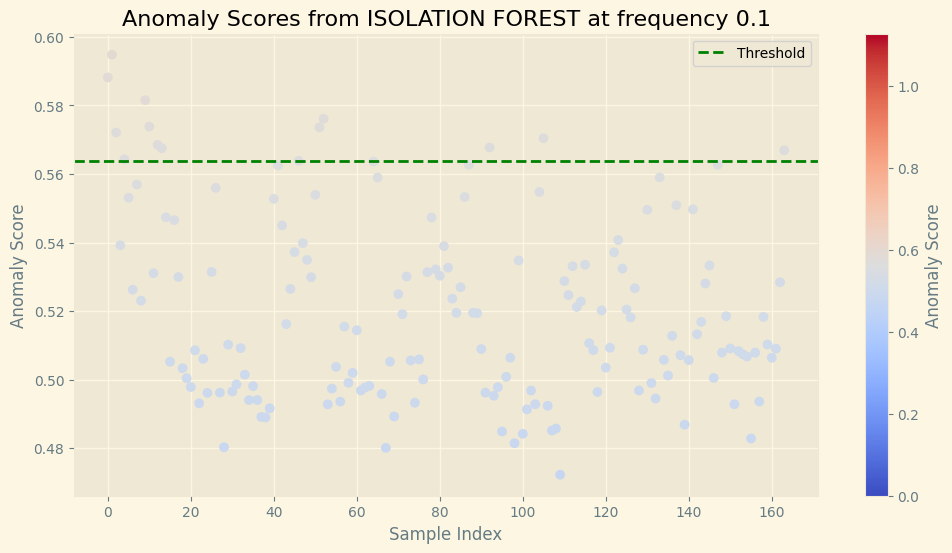

Number of anomalies detected: 14
Threshold: 0.5637
ROC AUC Score: 0.9542
F1 Score: 0.4490
Accuracy: 0.8354
Precision: 0.7857
Recall: 0.3143
              precision    recall  f1-score   support

           0       0.84      0.98      0.90       129
           1       0.79      0.31      0.45        35

    accuracy                           0.84       164
   macro avg       0.81      0.65      0.68       164
weighted avg       0.83      0.84      0.81       164



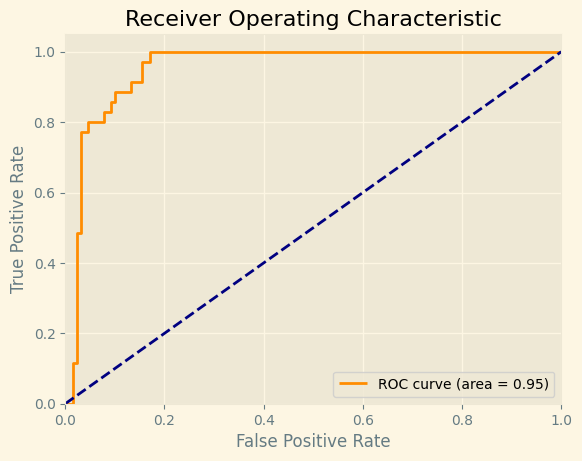

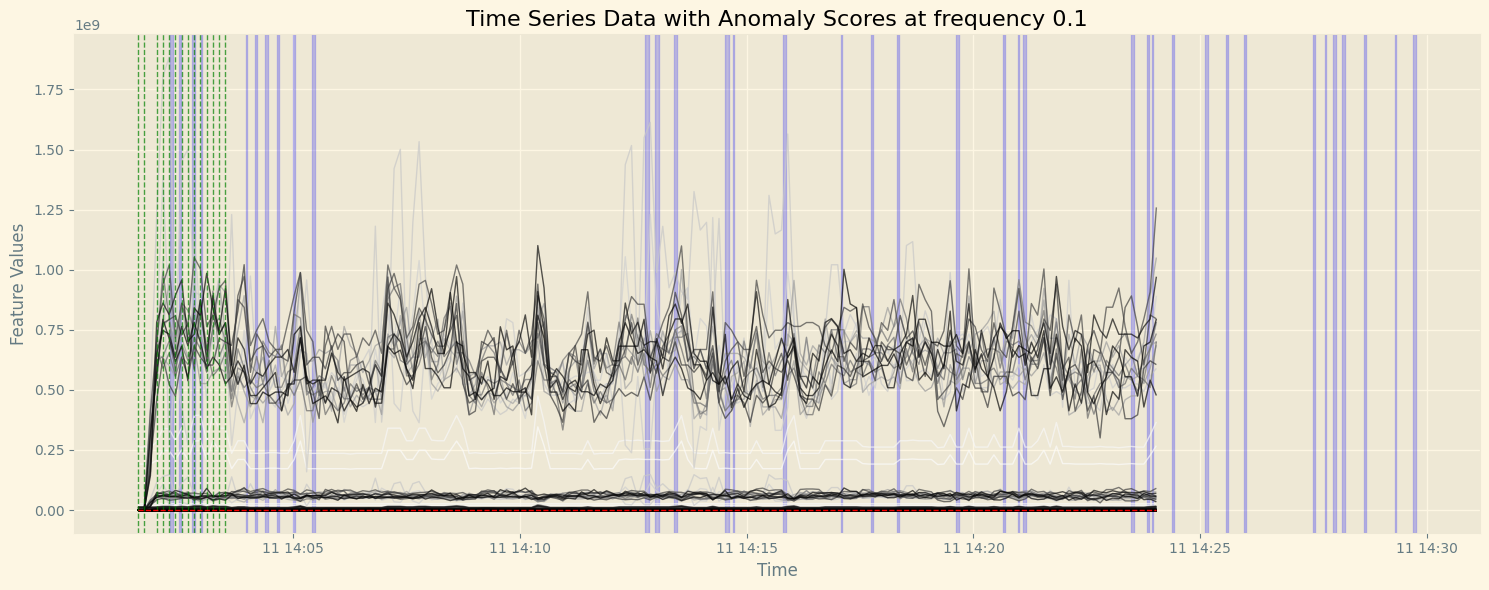

Top 14 Anomalies:
                timestamp  anomaly_score  \
1 2022-08-11 14:01:42.910       0.594786   
0 2022-08-11 14:01:34.644       0.588160   
0 2022-08-11 14:01:59.442       0.588160   
0 2022-08-11 14:02:07.708       0.588160   
0 2022-08-11 14:02:15.974       0.588160   
0 2022-08-11 14:02:24.240       0.588160   
0 2022-08-11 14:02:32.506       0.588160   
0 2022-08-11 14:02:40.772       0.588160   
0 2022-08-11 14:02:49.038       0.588160   
0 2022-08-11 14:02:57.304       0.588160   
0 2022-08-11 14:03:05.570       0.588160   
0 2022-08-11 14:03:13.836       0.588160   
0 2022-08-11 14:03:22.102       0.588160   
0 2022-08-11 14:03:30.368       0.588160   

   machine_nameKuka Robot_apparent_power-_Absolute energy  \
1                                       2.723880e+06        
0                                       2.731075e+06        
0                                       5.401697e+06        
0                                       6.059524e+06        
0               

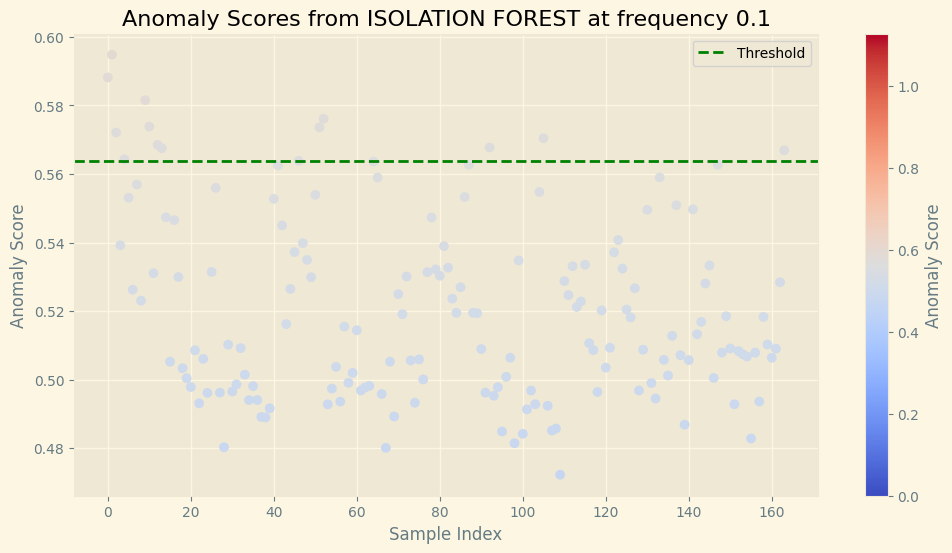

Number of anomalies detected: 14
Threshold: 0.5637
ROC AUC Score: 0.9542
F1 Score: 0.4490
Accuracy: 0.8354
Precision: 0.7857
Recall: 0.3143
              precision    recall  f1-score   support

           0       0.84      0.98      0.90       129
           1       0.79      0.31      0.45        35

    accuracy                           0.84       164
   macro avg       0.81      0.65      0.68       164
weighted avg       0.83      0.84      0.81       164



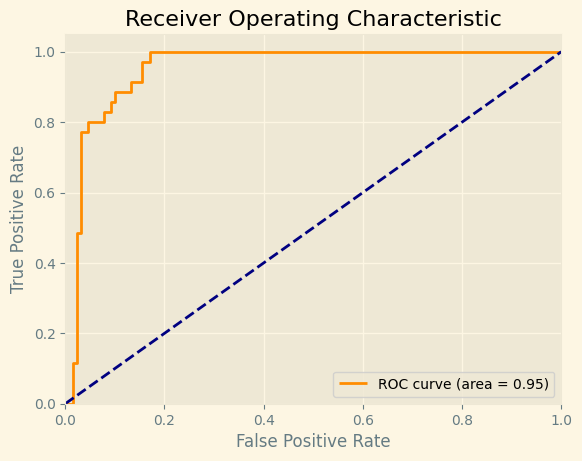

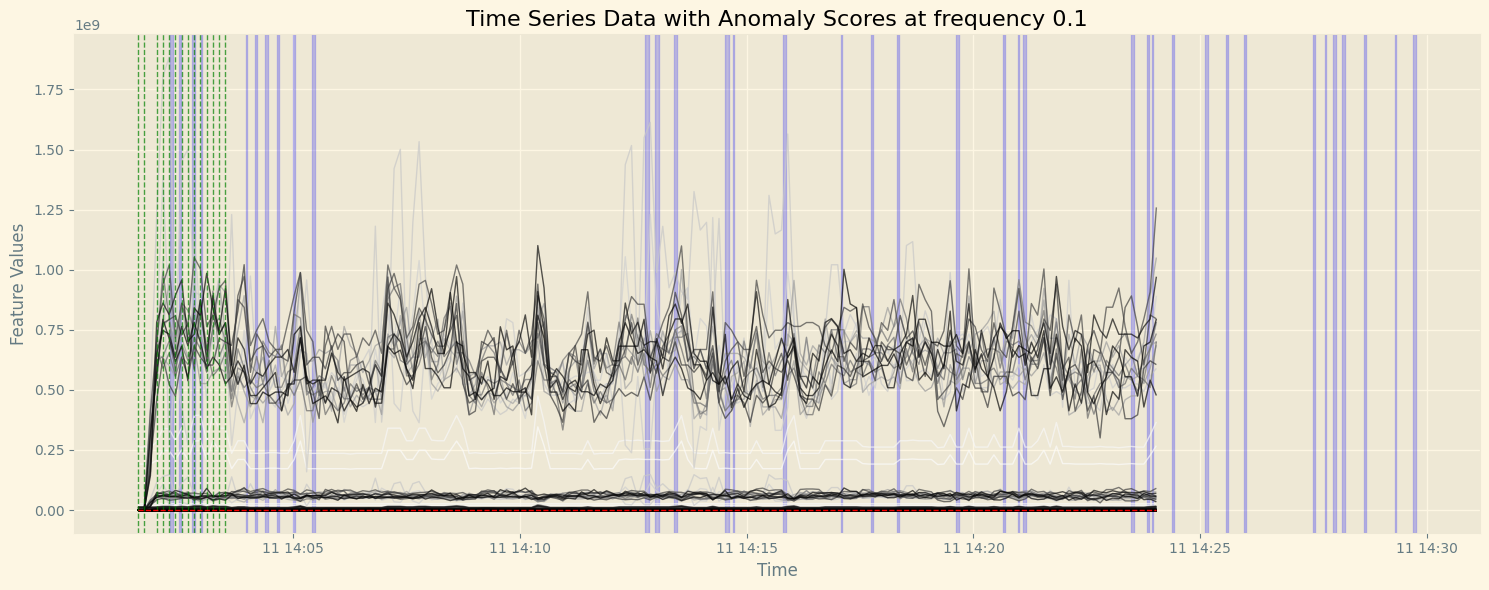

Top 14 Anomalies:
                timestamp  anomaly_score  \
1 2022-08-11 14:01:42.910       0.594786   
0 2022-08-11 14:01:34.644       0.588160   
0 2022-08-11 14:01:59.442       0.588160   
0 2022-08-11 14:02:07.708       0.588160   
0 2022-08-11 14:02:15.974       0.588160   
0 2022-08-11 14:02:24.240       0.588160   
0 2022-08-11 14:02:32.506       0.588160   
0 2022-08-11 14:02:40.772       0.588160   
0 2022-08-11 14:02:49.038       0.588160   
0 2022-08-11 14:02:57.304       0.588160   
0 2022-08-11 14:03:05.570       0.588160   
0 2022-08-11 14:03:13.836       0.588160   
0 2022-08-11 14:03:22.102       0.588160   
0 2022-08-11 14:03:30.368       0.588160   

   machine_nameKuka Robot_apparent_power-_Absolute energy  \
1                                       2.723880e+06        
0                                       2.731075e+06        
0                                       5.401697e+06        
0                                       6.059524e+06        
0               

In [26]:
for anomaly_scores in anomaly_scores_s:
    threshold_1 = np.mean(anomaly_scores) + 2 * np.std(anomaly_scores)

    median = np.median(anomaly_scores)
    mad = np.median(np.abs(anomaly_scores - median))
    threshold_2 = median + 3 * mad

    threshold_3 = np.percentile(anomaly_scores, 95)

    Q1 = np.percentile(anomaly_scores, 25)
    Q3 = np.percentile(anomaly_scores, 75)
    IQR = Q3 - Q1
    threshold_4 = Q3 + 1.5 * IQR

    for threshold in [threshold_1, threshold_2, threshold_3, threshold_4]:
        anomalies_detected = sum(anomaly_scores >= threshold)
        print(f"Number of anomalies detected: {anomalies_detected} with threshold {threshold}")

    anomalies_detected = plot_anomalies(anomaly_scores, freq, threshold_2, "ISOLATION FOREST")
    compute_metrics(anomaly_scores, y_test_collision, threshold_2)
    plot_roc_curve(y_test_collision.values, anomaly_scores)
    plot_anomalies_over_time(X_test, anomaly_scores, anomalies_detected, freq, threshold_2, collision_zones, X_test_start_end)

In [27]:
y_test_collision

0    0
1    0
2    0
0    0
0    1
    ..
0    0
0    0
0    0
0    1
0    1
Name: is_collision, Length: 164, dtype: int64

In [28]:
# for idx, anomaly_scores in enumerate(anomaly_scores_s):
#     anomalies_detected = plot_anomalies(anomaly_scores, freq, threshold_2, "RANDOM FOREST")

In [29]:
#Controlla se c'è da cambiare labels o meno
# for idx, pred in enumerate(pred_s):
#     #ATTENZIONE, mapping delle anomalie da dominio [-1, 1] a [0, 1]
#     # pred[pred == 1] = 0
#     # pred[pred == -1] = 1
#     compute_metrics(anomaly_scores, y_test_collision, threshold_2)

In [30]:
# for pred in pred_s:
#     plot_roc_curve(y_test_collision.values, pred)

## Map anomalies to original time series

In [31]:
# def plot_anomalies_over_time_isolation_forest(X_test, pred, freq, collision_zones, X_test_start_end):
#     # Step 1: Create a DataFrame with the original data and anomaly scores
#     df = X_test.copy()

#     # Step 2: Add a timestamp column since it doesn't exist
#     df['timestamp'] = pd.date_range(start=X_test_start_end['start'].to_list()[0], end=X_test_start_end['end'].to_list()[-1], periods=len(df))  #Qua assicurati di bindare bene i timestamp (se puoi, non generarli)

#     print(df['timestamp'])

#     # Step 3: Select a few features to plot along with the anomaly scores
#     features_to_plot = df.columns.drop(['timestamp'])

#     # Step 4: Create the plot
#     fig, ax1 = plt.subplots(figsize=(15, 6))
#     ax1.set_title(f'Time Series Data with Anomaly Scores at frequency {freq}', fontsize=16)
    
#     # Plot features on primary y-axis
#     ax1.set_xlabel('Time')
#     ax1.set_ylabel('Feature Values')
#     colors = plt.cm.Greys(np.linspace(0, 1, len(features_to_plot)))
#     lines = []  # To collect plot lines for legend
#     labels = []  # To collect plot labels for legend
    
#     # print(f"THRESH: {threshold}")
#     for feature, color in zip(features_to_plot, colors):
#         # if any(df[feature] > threshold):
#         line, = ax1.plot(df['timestamp'], df[feature], label=f'Feature: {feature}', linewidth=1, color=color, alpha=0.7)
#         lines.append(line)
#         labels.append(f'Feature: {feature}')
#         # else:
#             # print("\t\tQuesta feature non supera mai soglia")

#     #Highlighting collision zones on the graph
#     for s, e in zip(collision_zones['start'].tolist(), collision_zones['end'].tolist()):
#         ax1.axvspan(s, e, alpha=0.2, color='blue')

#     # ax1.plot(df['timestamp'], df['anomaly_score'], color='red', label='Anomaly Score', linestyle='--', linewidth=1)
#     ax1.plot(df['timestamp'], pred, 'go-', label='Anomaly Score', linestyle='--', linewidth=1)

#     fig.tight_layout()
#     plt.show()

In [32]:
# for pred in pred_s:
#     plot_anomalies_over_time_isolation_forest(X_test, pred, freq, collision_zones, X_test_start_end)